In [2]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from tqdm import trange, tqdm
from matplotlib.pyplot import *

%matplotlib inline

In [3]:
# figure styling
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

rcParams['figure.figsize'] = (13,4.5)
rcParams['figure.dpi'] = 200

In [4]:
images = np.load('../data/stim.npy')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/sub.csv')

dd = np.load('../data/features.npz')
features = dict()
for k in dd.keys():
    features[k] = dd[k]

    
conv_train = np.load('../data/conv_train.npy').flat[0]
conv_test = np.load('../data/conv_test.npy').flat[0]

conv_features = dict()
for k in conv_train.keys():
    conv_features[k] = np.vstack([conv_test[k], conv_train[k]])

In [5]:
features.keys()

dict_keys(['raw', 'LAB', 'fourier', 'gabor', 'stats', 'stats_LAB'])

In [6]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

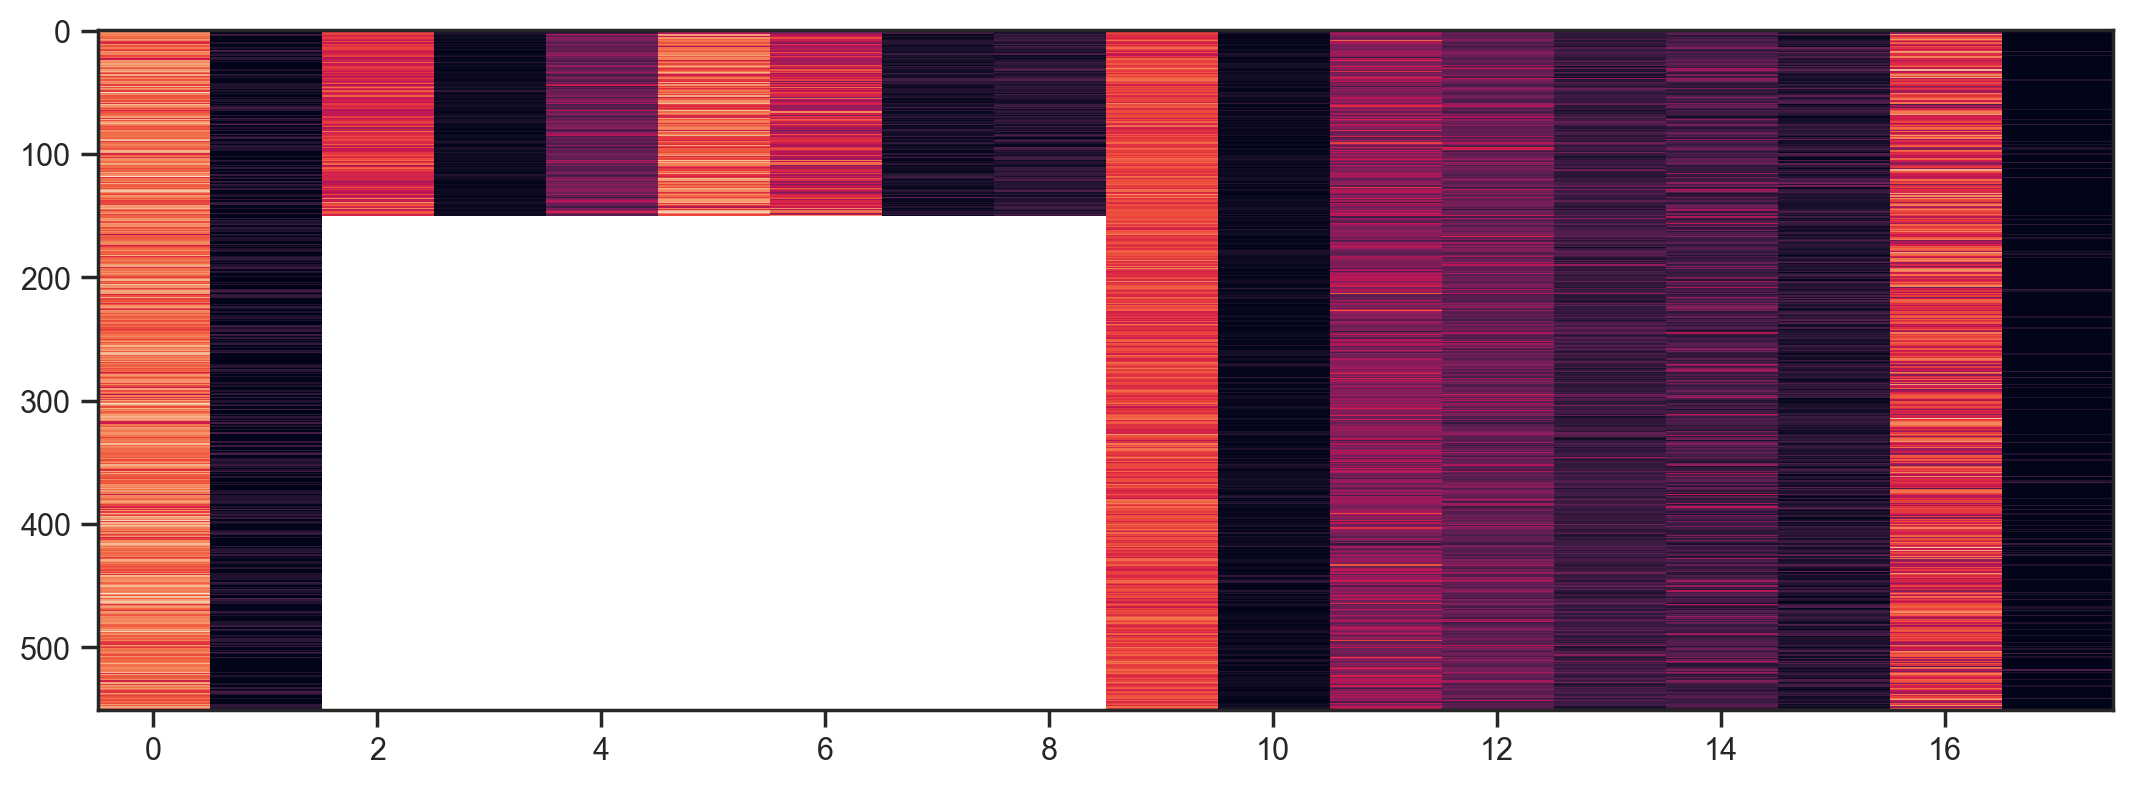

In [7]:
responses = np.array(train.iloc[:, 1:])

imshow(responses, aspect='auto')

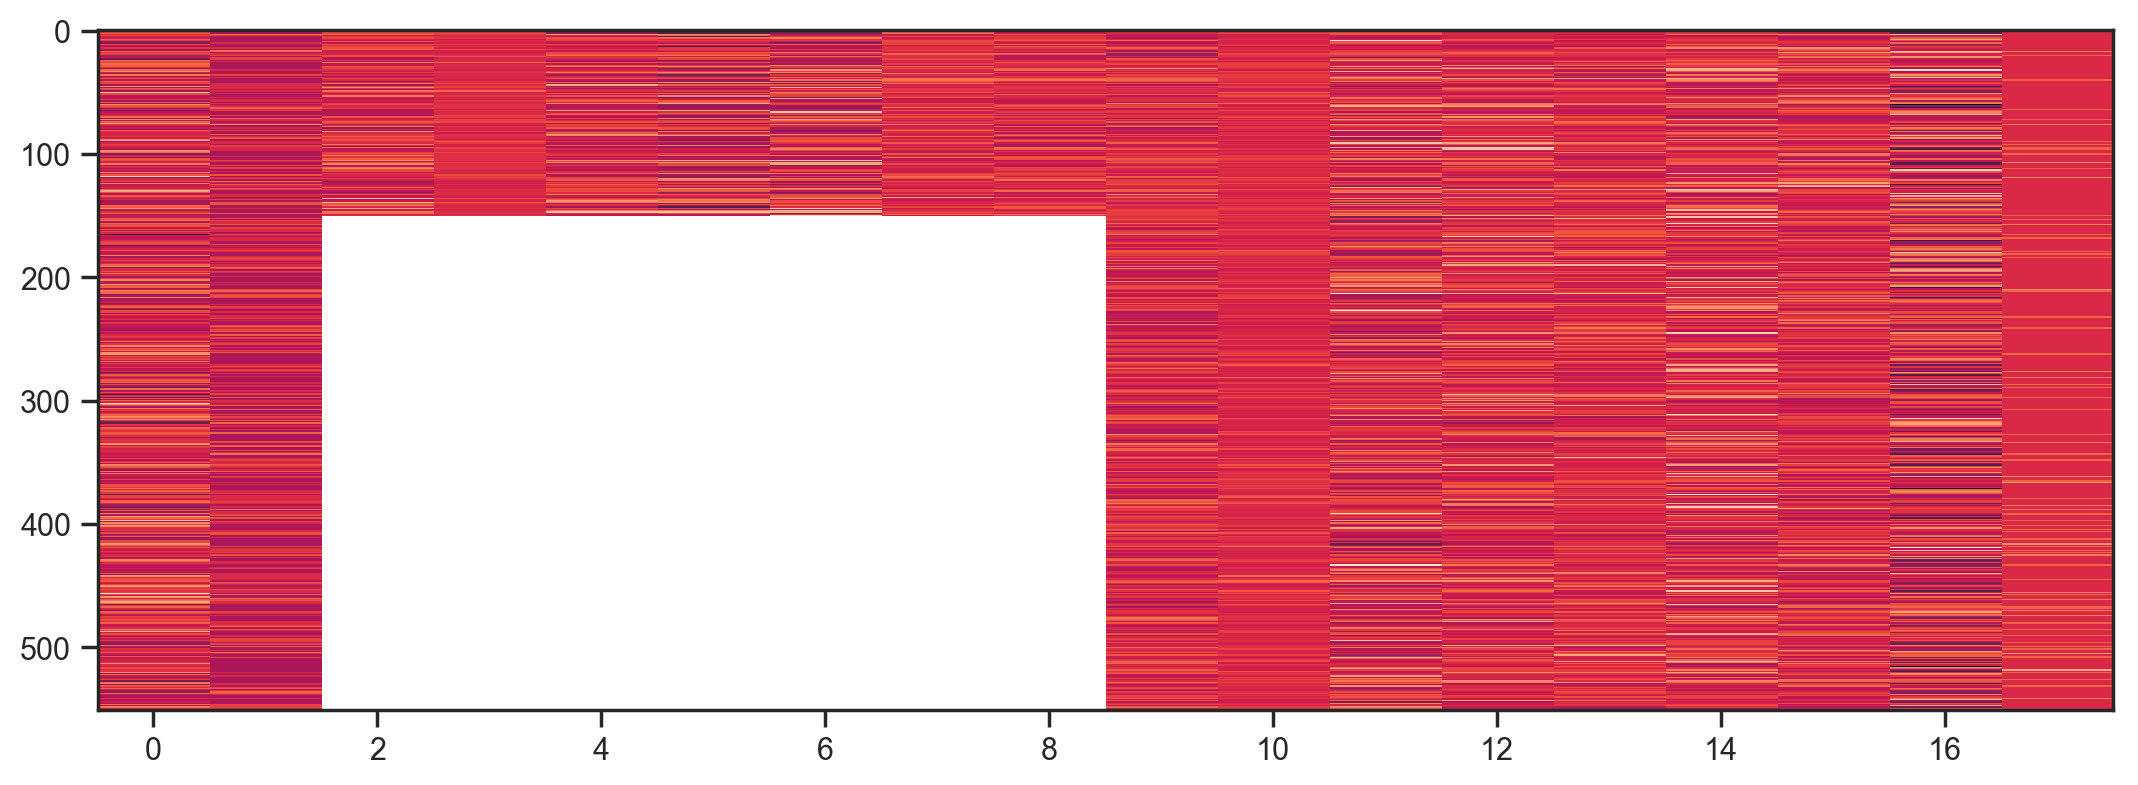

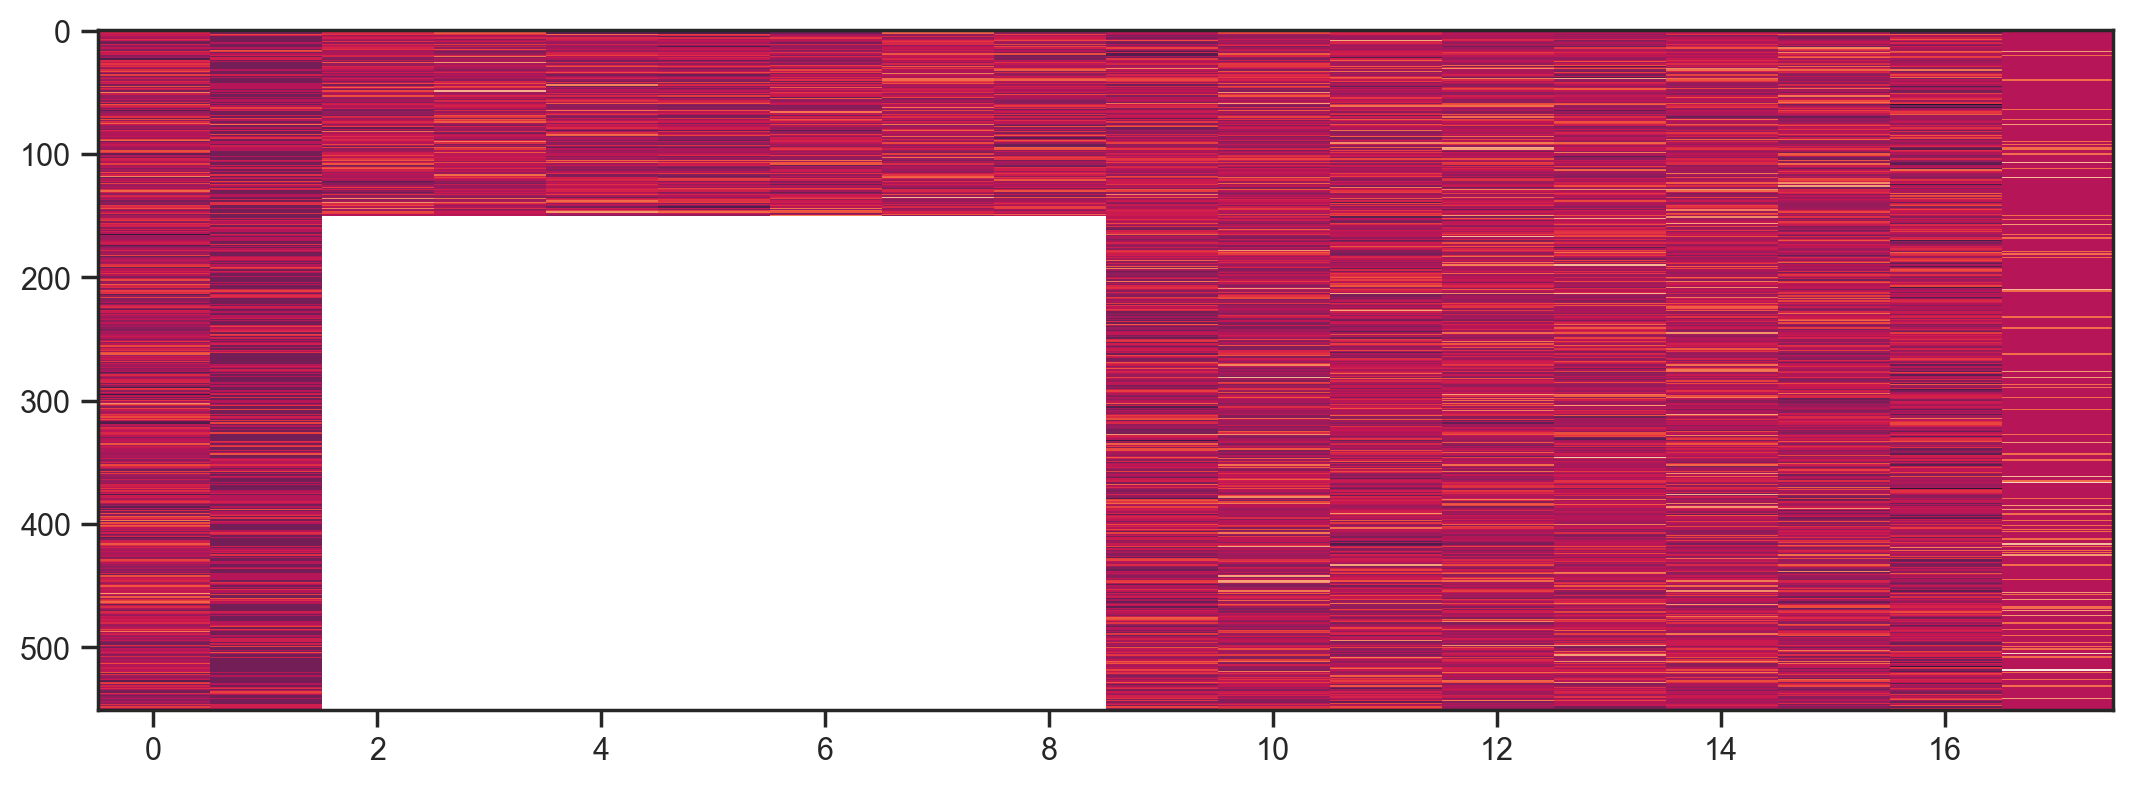

In [8]:
responses_demean = np.copy(responses)
responses_std = np.copy(responses)

means = []
stds = []

for r in range(responses.shape[1]):
    vals = responses[:, r]
    vs = vals[~np.isnan(vals)]
    responses_demean[:, r] = vals - np.median(vs)
    responses_std[:, r] = (vals - np.median(vs)) / np.std(vs)
    
    means.append(np.median(vs))
    stds.append(np.std(vs))
    
means = np.array(means)
stds = np.array(stds)
    
imshow(responses_demean, aspect='auto')

figure()
imshow(responses_std, aspect='auto')

Using TensorFlow backend.


Imputing row 1/551 with 0 missing, elapsed time: 0.057
Imputing row 101/551 with 0 missing, elapsed time: 0.058
Imputing row 201/551 with 7 missing, elapsed time: 0.063
Imputing row 301/551 with 7 missing, elapsed time: 0.073
Imputing row 401/551 with 7 missing, elapsed time: 0.083
Imputing row 501/551 with 7 missing, elapsed time: 0.092


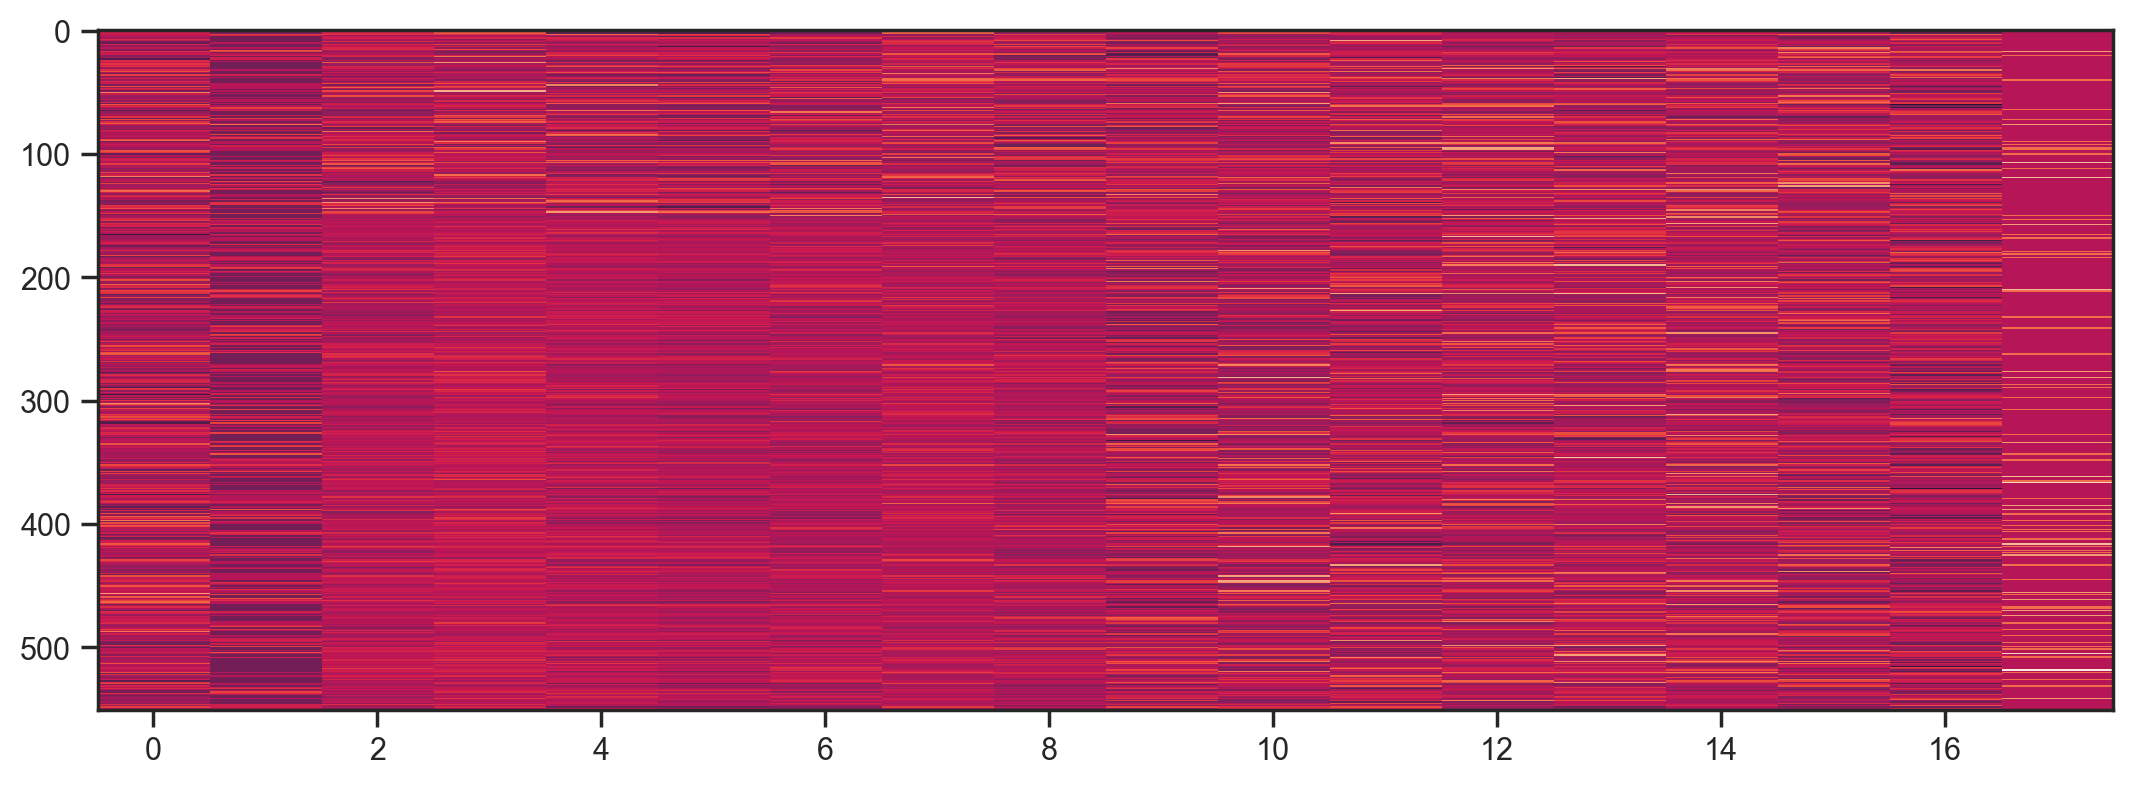

In [9]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

responses_imputed = KNN(k=5).fit_transform(responses_std)
# responses_imputed = SoftImpute().fit_transform(responses_std)

imshow(responses_imputed, aspect='auto')

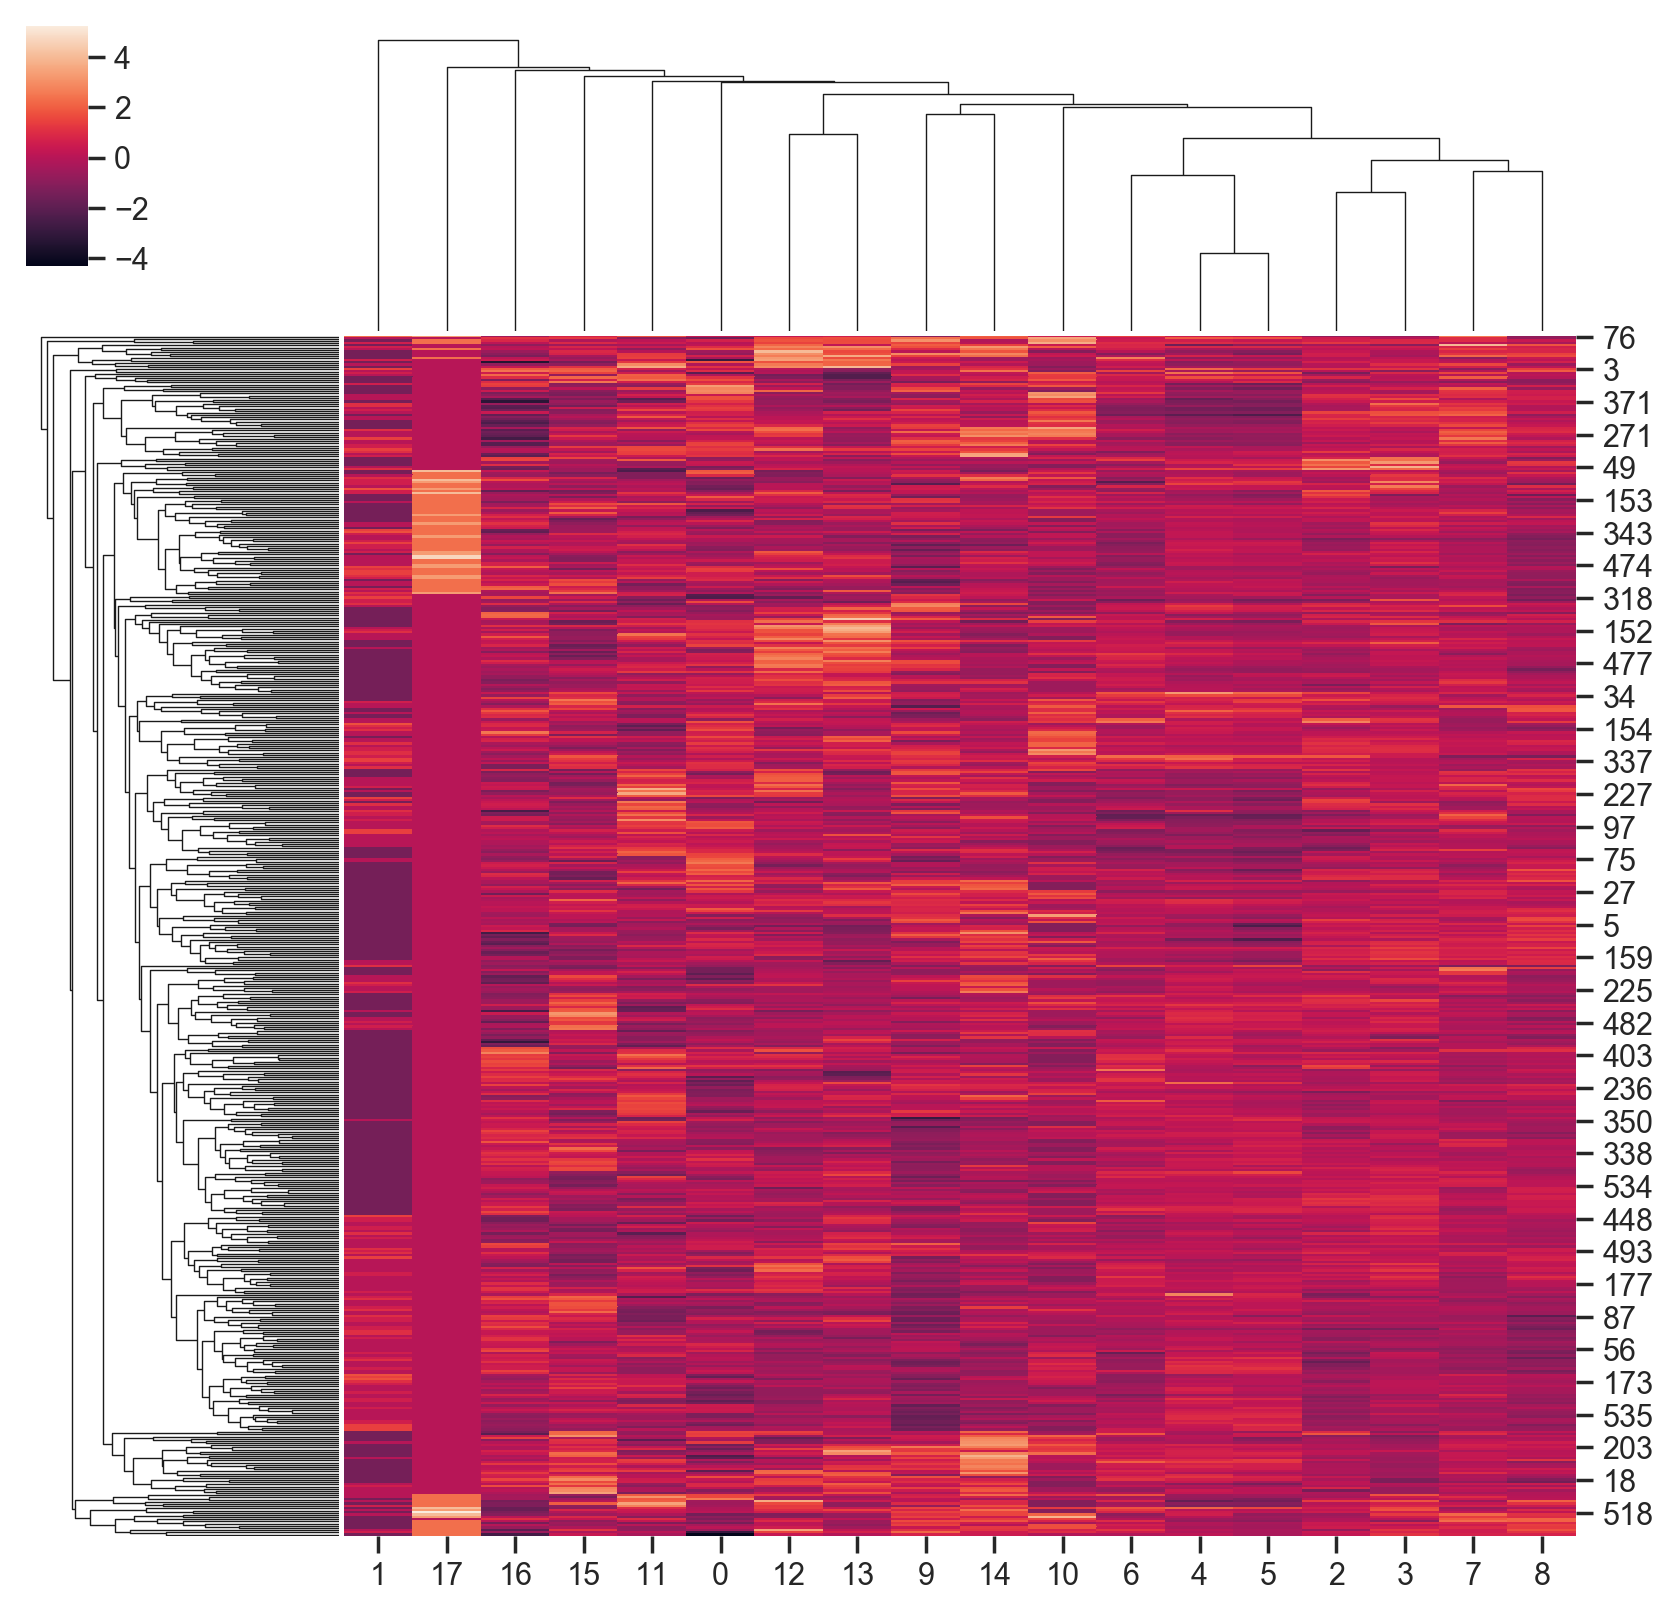

In [10]:
sns.clustermap(responses_imputed)

In [11]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor


import umap

/home/pierre/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

In [13]:
pcs_lab = PCA(n_components=50).fit_transform(features['LAB'])
pcs_fourier = PCA(n_components=20).fit_transform(features['fourier'])
pcs_gabor = PCA(n_components=20).fit_transform(features['gabor'])

In [14]:
pcs_conv1 = PCA(n_components=30).fit_transform(conv_features['conv1'])
pcs_conv2 = PCA(n_components=20).fit_transform(conv_features['conv2'])
pcs_conv3 = PCA(n_components=20).fit_transform(conv_features['conv3'])
pcs_conv4 = PCA(n_components=20).fit_transform(conv_features['conv4'])
pcs_conv5 = PCA(n_components=10).fit_transform(conv_features['conv5'])


In [15]:
images_flat = images[:, 20:-20,20:-20].reshape(images.shape[0], -1)
# images_flat = images.reshape(images.shape[0], -1)
pcs_raw = PCA(n_components=50).fit_transform(images_flat)

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=50)
X_embed = embedding.fit_transform(images_flat)

In [16]:
# X_all = np.hstack([X_embed, features['stats'], pcs_lab, pcs_gabor])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv1, pcs_conv2, pcs_conv3, pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv3, pcs_conv4])
X_all = np.hstack([X_embed, features['stats'], features['stats_LAB'],
                   pcs_lab, pcs_conv1, pcs_conv4, pcs_conv5])

# X_all = np.hstack([conv_features['conv1'], conv_features['conv4'], conv_features['conv5']])

In [17]:
def make_names_vec(X, prefix):
    return ['{}_{}'.format(prefix, i) for i in range(X.shape[1])]

In [18]:
stat_names = ['min', 'max', 'rms', 'mean', 'std'] + ['moment_' + str(i) for i in range(3,7)]
stat_feature_names = ['{}_{}'.format(s, x) for x in ['r','g','b'] for s in stat_names ]
stat_lab_names = ['{}_{}'.format(s, x) for x in ['L', 'a', 'b'] for s in stat_names]

names = np.hstack([
    make_names_vec(X_embed, 'UMAP'),
    stat_feature_names,
    stat_lab_names,
    make_names_vec(pcs_lab, 'PC_LAB'),
    make_names_vec(pcs_conv1, 'PC_CONV1'),
    make_names_vec(pcs_conv4, 'PC_CONV4'),
    make_names_vec(pcs_conv5, 'PC_CONV5')
])


In [19]:
model = ExtraTreesRegressor(max_depth=15, n_estimators=100)

importances = []

for i in trange(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    importances.append(model.feature_importances_)
    
importances = np.array(importances)

100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


115


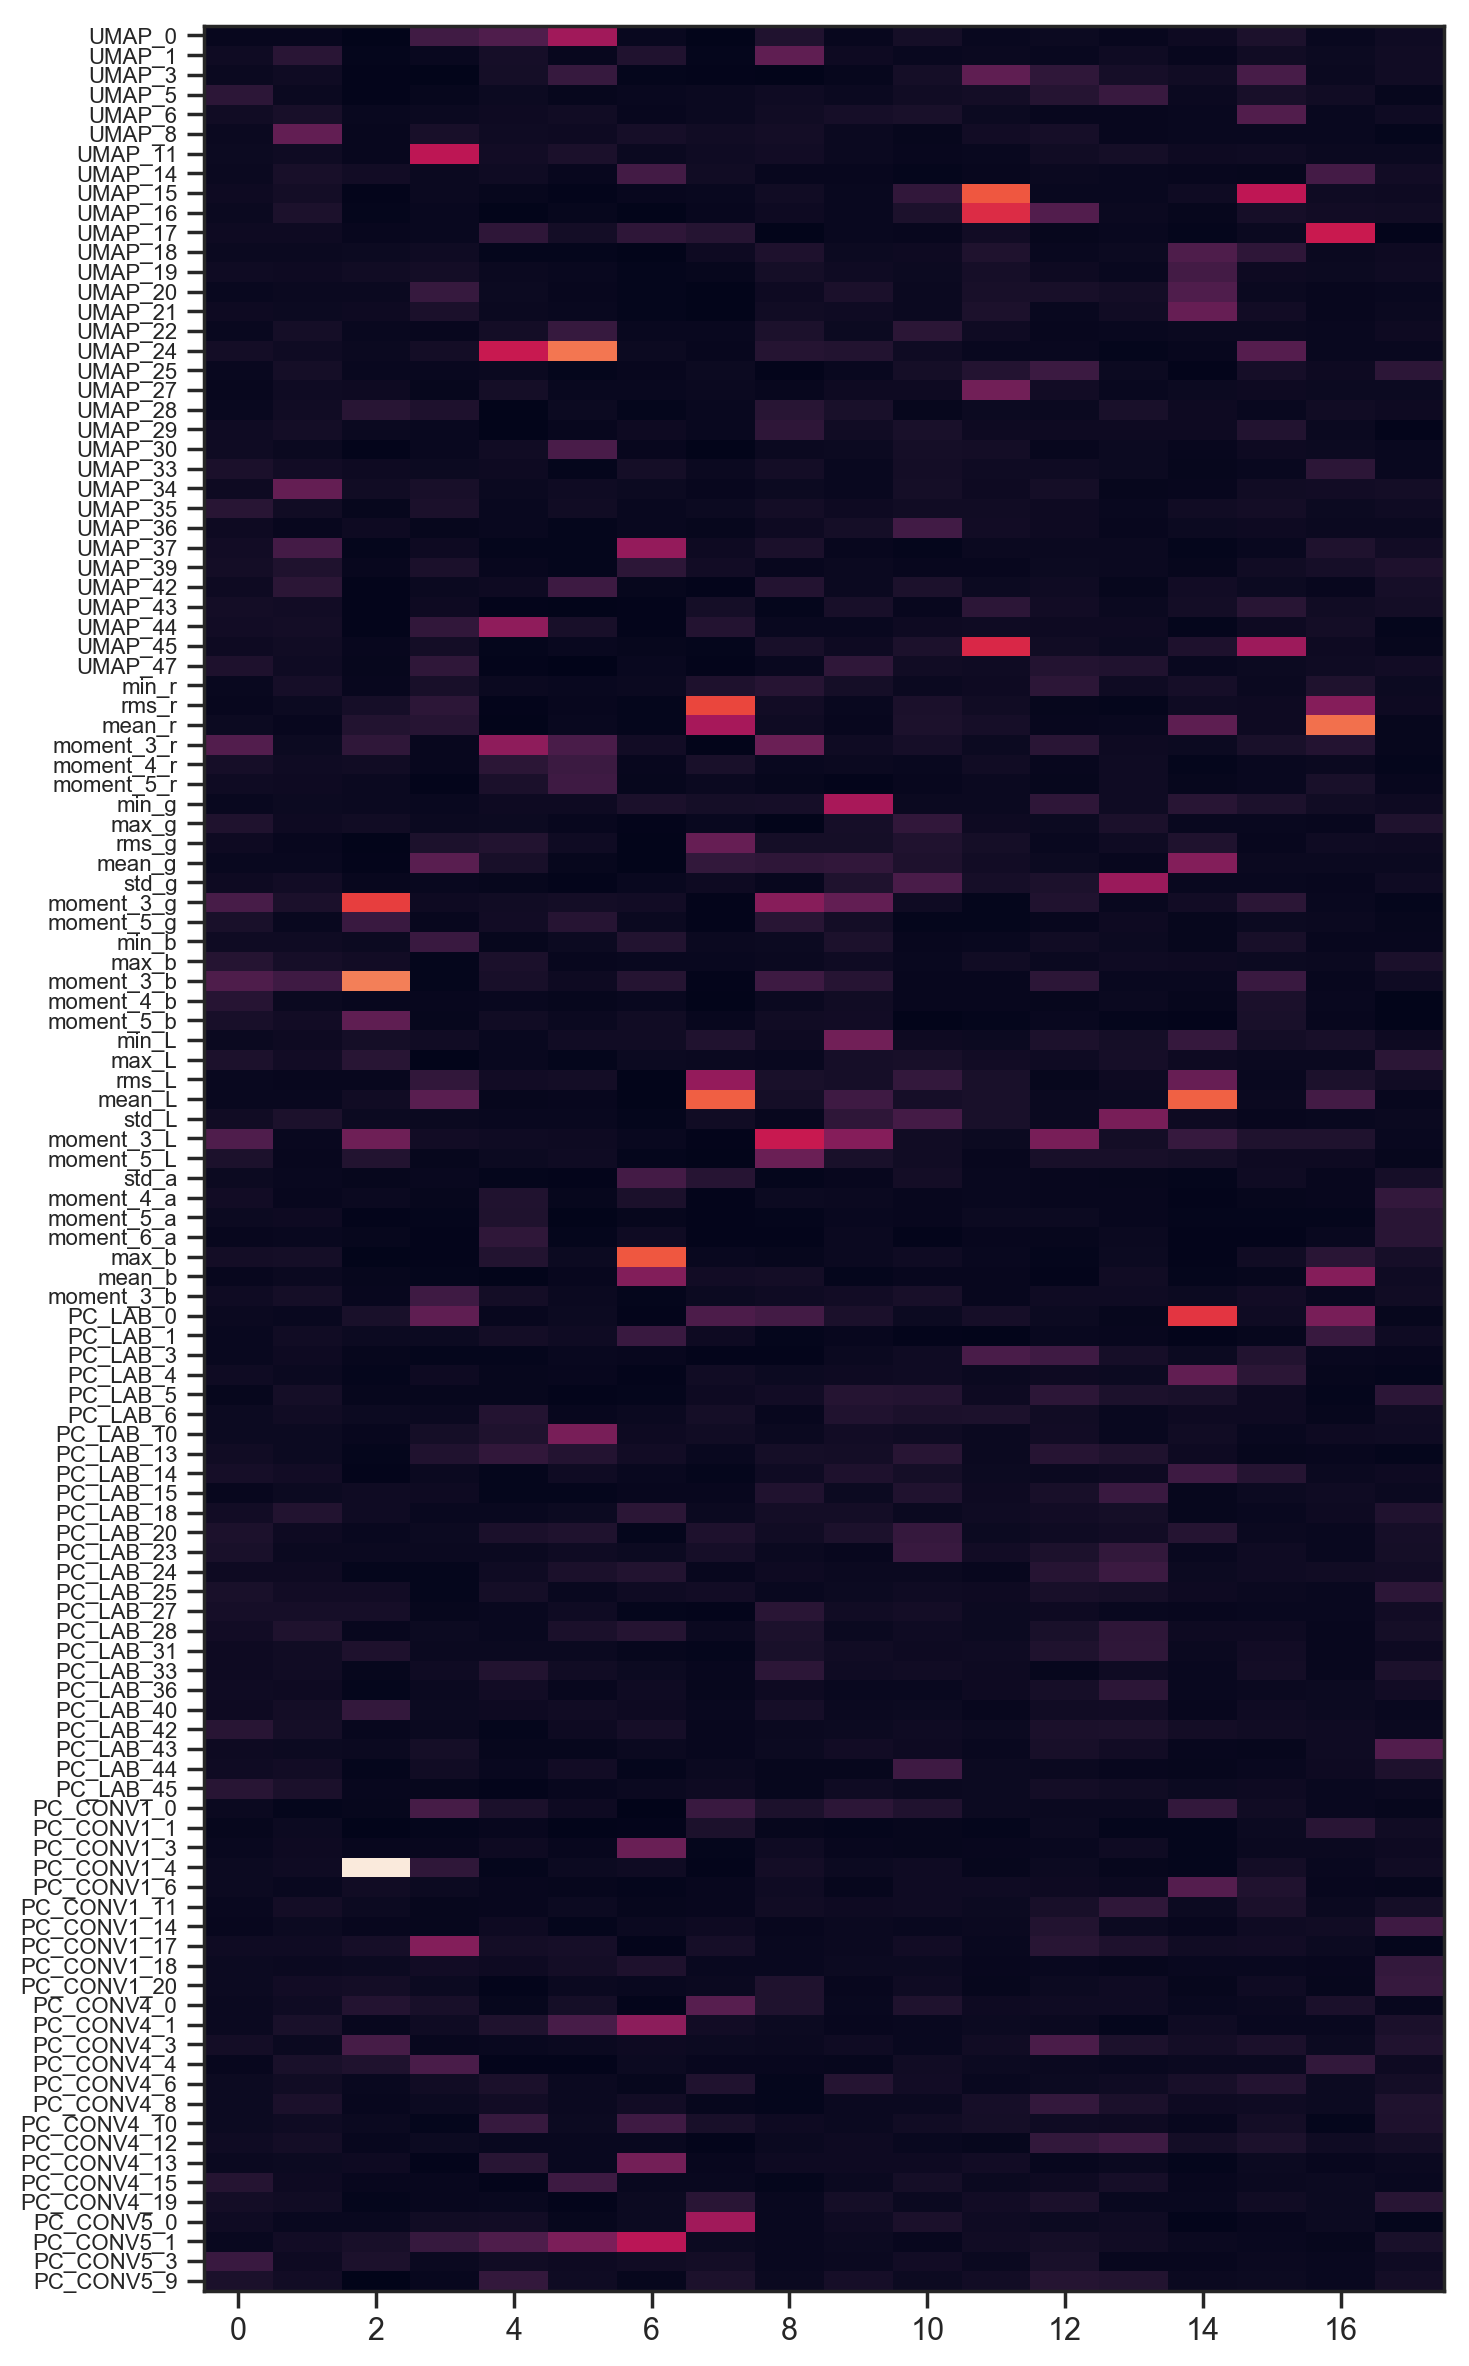

In [20]:
# good_features = np.sum(importances > 0.01, axis=0) > 0

## pick out the top 5% features for each neuron
good_features = np.sum(importances.T > np.percentile(importances, 95, axis=1), axis=1) > 0
print(np.sum(good_features))

fig = figure(figsize=(8,15))
ax = gca()

importances_crop = importances[:,good_features]
names_crop = names[good_features]

imshow(importances_crop.T, aspect='auto')
ax.set_yticks(range(len(names_crop)))
_ = ax.set_yticklabels(names_crop, fontsize=8)
# ''

# _ = setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

43


''

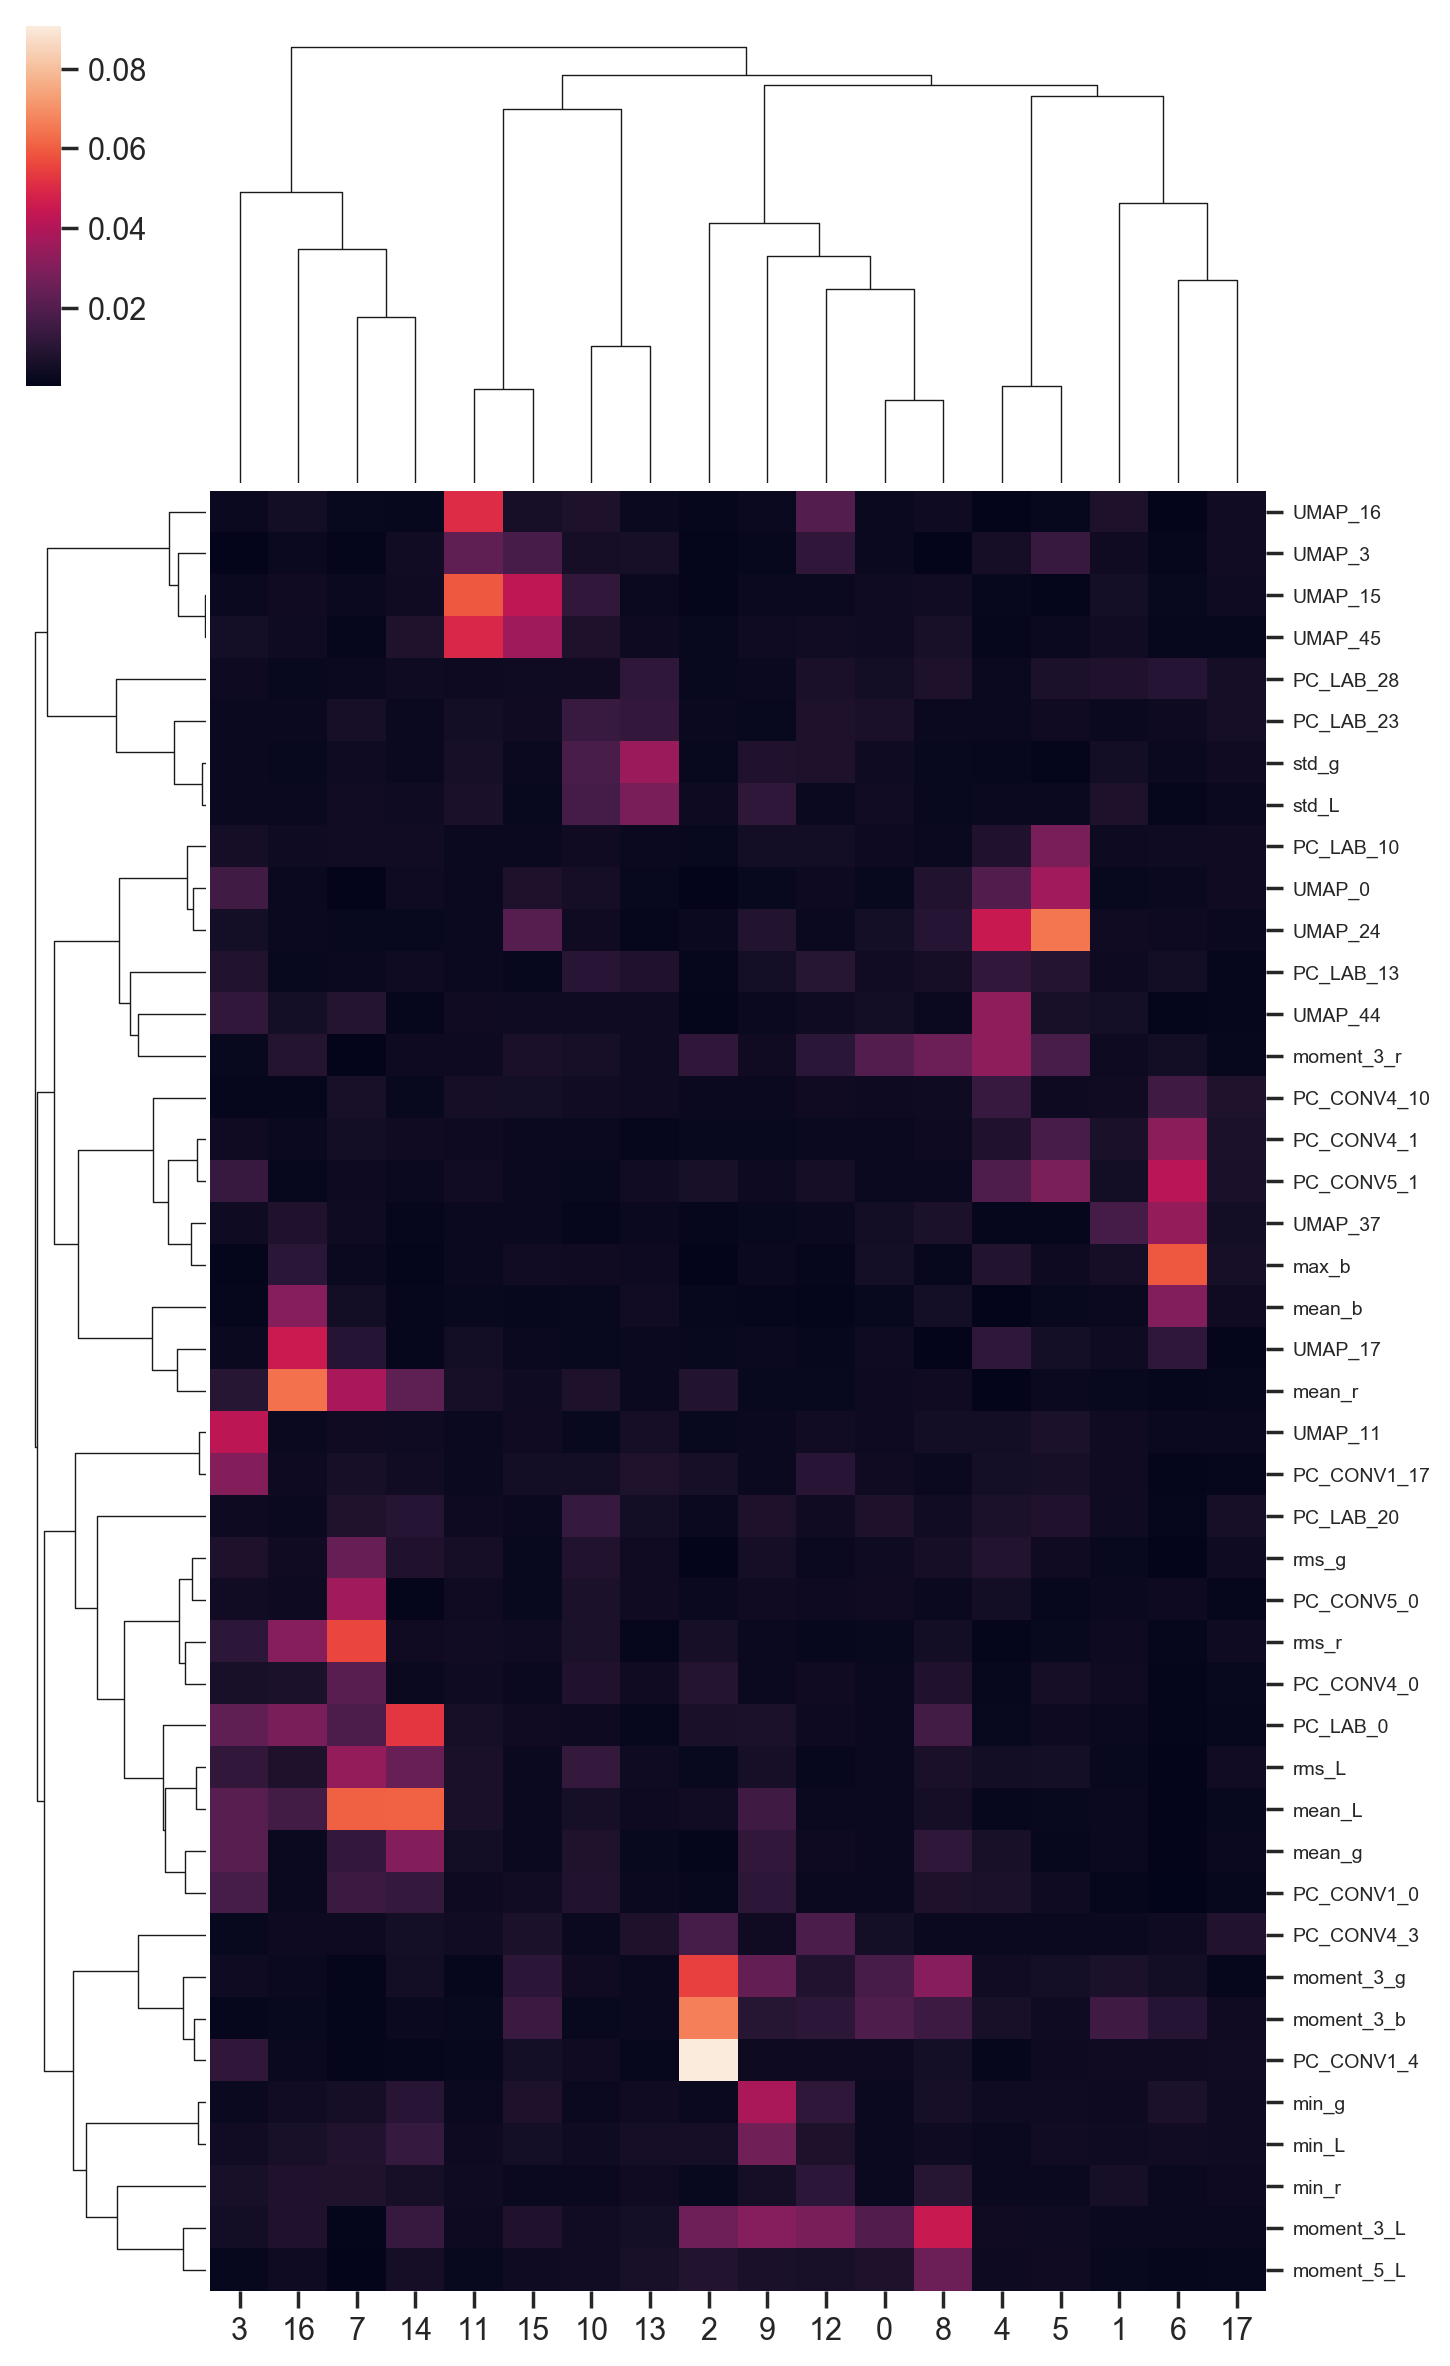

In [21]:
# good_features = np.sum(importances > 0.01, axis=0) > 0

summed = np.sum(importances, axis=0)
good_features = summed > np.percentile(summed, 80)
# good_features = np.sum(importances.T > np.percentile(importances, 98, axis=1), axis=1) > 0
print(np.sum(good_features))

importances_crop = importances[:,good_features]
names_crop = names[good_features]

df = pd.DataFrame(importances_crop, columns=names_crop)

g = sns.clustermap(df.T, yticklabels=1, figsize=(8,15), metric='correlation')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=7)
''

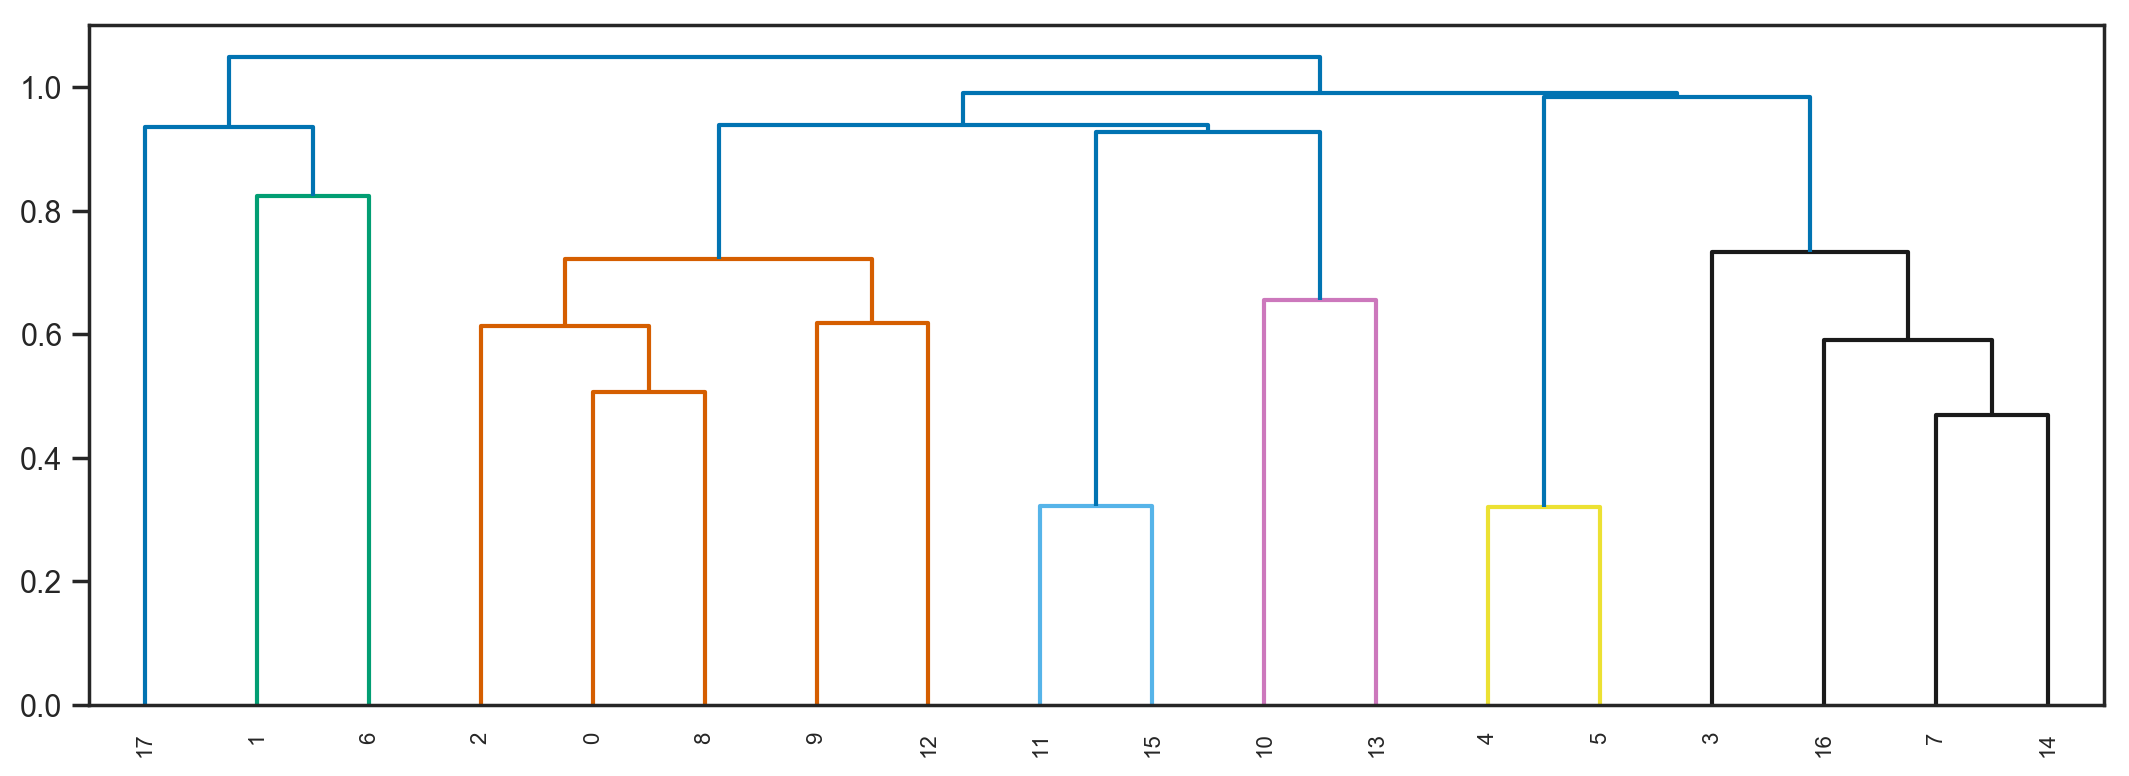

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster


Z = linkage(importances, 'weighted', 'correlation')

t = 0.8*np.max(Z[:,2])

_ = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=t
)

clusters = fcluster(Z, t, criterion='distance')

In [23]:
np.unique(clusters)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [24]:
for c in np.unique(clusters):
    check = np.where(clusters == c)[0]
    print('cluster {}'.format(c))
    for i in check:
        top = np.argsort(-importances[i])[:8]
        print(i, '\t',', '.join(names[top]))

cluster 1
1 	 UMAP_34, UMAP_8, UMAP_37, moment_3_b, UMAP_42, UMAP_1, PC_LAB_18, PC_LAB_28
6 	 max_b, PC_CONV5_1, UMAP_37, PC_CONV4_1, mean_b, PC_CONV4_13, PC_CONV1_3, std_a
cluster 2
17 	 PC_LAB_43, PC_CONV1_14, PC_CONV1_20, moment_4_a, PC_CONV1_18, PC_LAB_5, PC_LAB_25, UMAP_25
cluster 3
0 	 moment_3_r, moment_3_L, moment_3_b, moment_3_g, PC_CONV5_3, UMAP_5, PC_LAB_45, UMAP_35
2 	 PC_CONV1_4, moment_3_b, moment_3_g, moment_3_L, moment_5_b, PC_CONV4_3, moment_5_g, PC_LAB_40
8 	 moment_3_L, moment_3_g, moment_3_r, moment_5_L, UMAP_1, PC_LAB_0, moment_3_b, mean_g
9 	 min_g, moment_3_L, min_L, moment_3_g, mean_L, mean_g, UMAP_47, std_L
12 	 moment_3_L, UMAP_16, PC_CONV4_3, PC_LAB_3, UMAP_25, PC_CONV4_8, PC_CONV4_12, UMAP_3
cluster 4
11 	 UMAP_15, UMAP_16, UMAP_45, UMAP_27, UMAP_3, PC_LAB_3, UMAP_43, UMAP_25
15 	 UMAP_15, UMAP_45, UMAP_24, UMAP_6, UMAP_3, moment_3_b, UMAP_18, PC_LAB_4
cluster 5
10 	 std_g, std_L, UMAP_36, PC_LAB_44, PC_LAB_23, PC_LAB_20, rms_L, max_g
13 	 std_g, std_L, PC_C

In [25]:
def get_mega_image(images, ncols=5):
    rows = []
    row = []
    for i, im in enumerate(images):
        row.append(im[20:-20, 20:-20])
        if (i+1) % ncols == 0:
            rows.append(np.hstack(row))
            row = []
    if len(row) > 0:
        black = np.zeros(row[0].shape)
        while len(row) < ncols:
            row.append(black)
        rows.append(np.hstack(row))
    im = np.vstack(rows)
    return im

def visualize_images(images, ncols=5):
    im = get_mega_image(images, ncols)
    imshow(im)
    axis('off')
    
def visualize_feature(images, feature, samples=10):
    high = np.argsort(-feature)[:samples]
    low = np.argsort(feature)[:samples]
    ims = np.vstack([images[high], images[low]])
    visualize_images(ims, ncols=samples)

In [26]:
summed = np.sum(importances, axis=0)
good_features = summed > np.percentile(summed, 90)
ixs = np.where(good_features)[0]

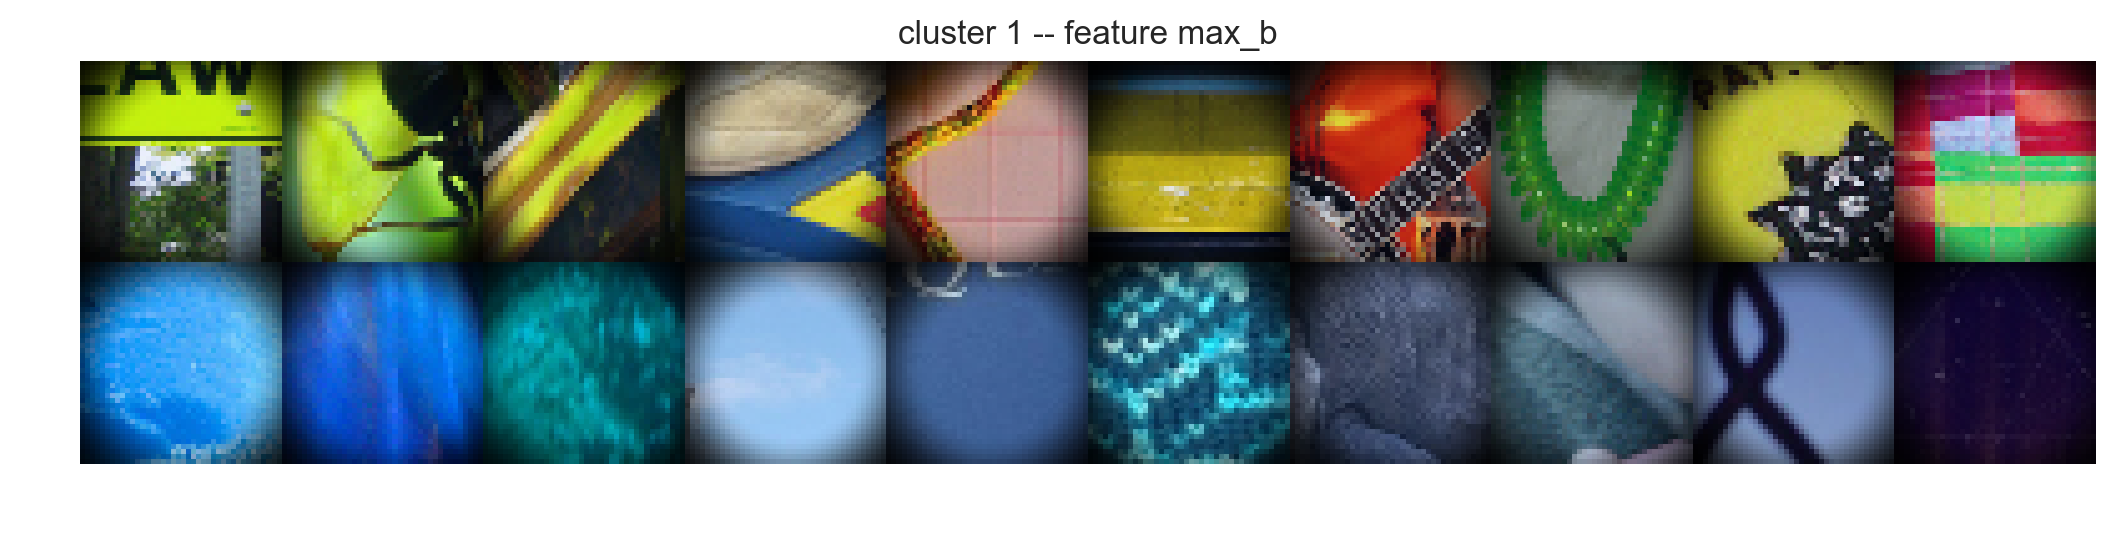

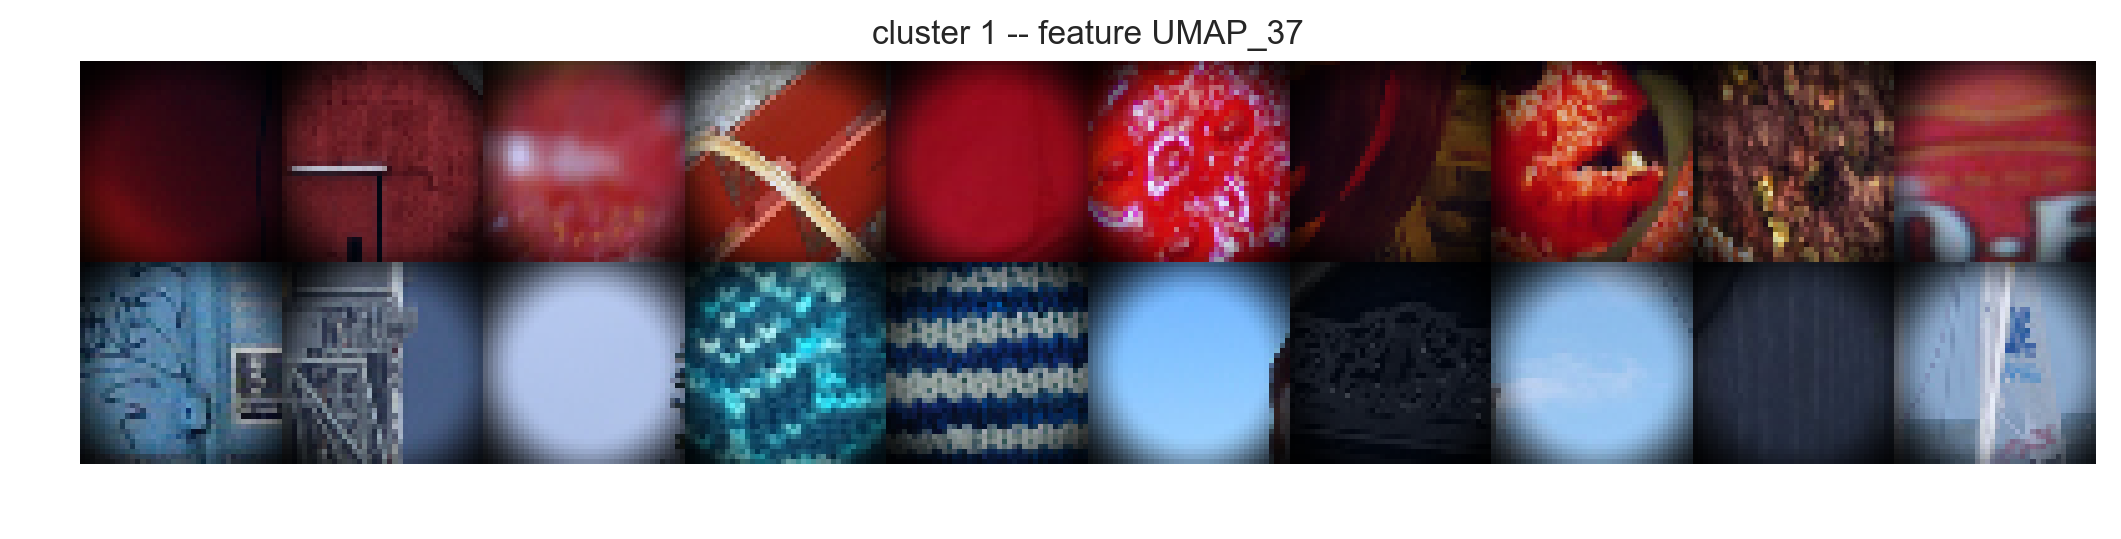

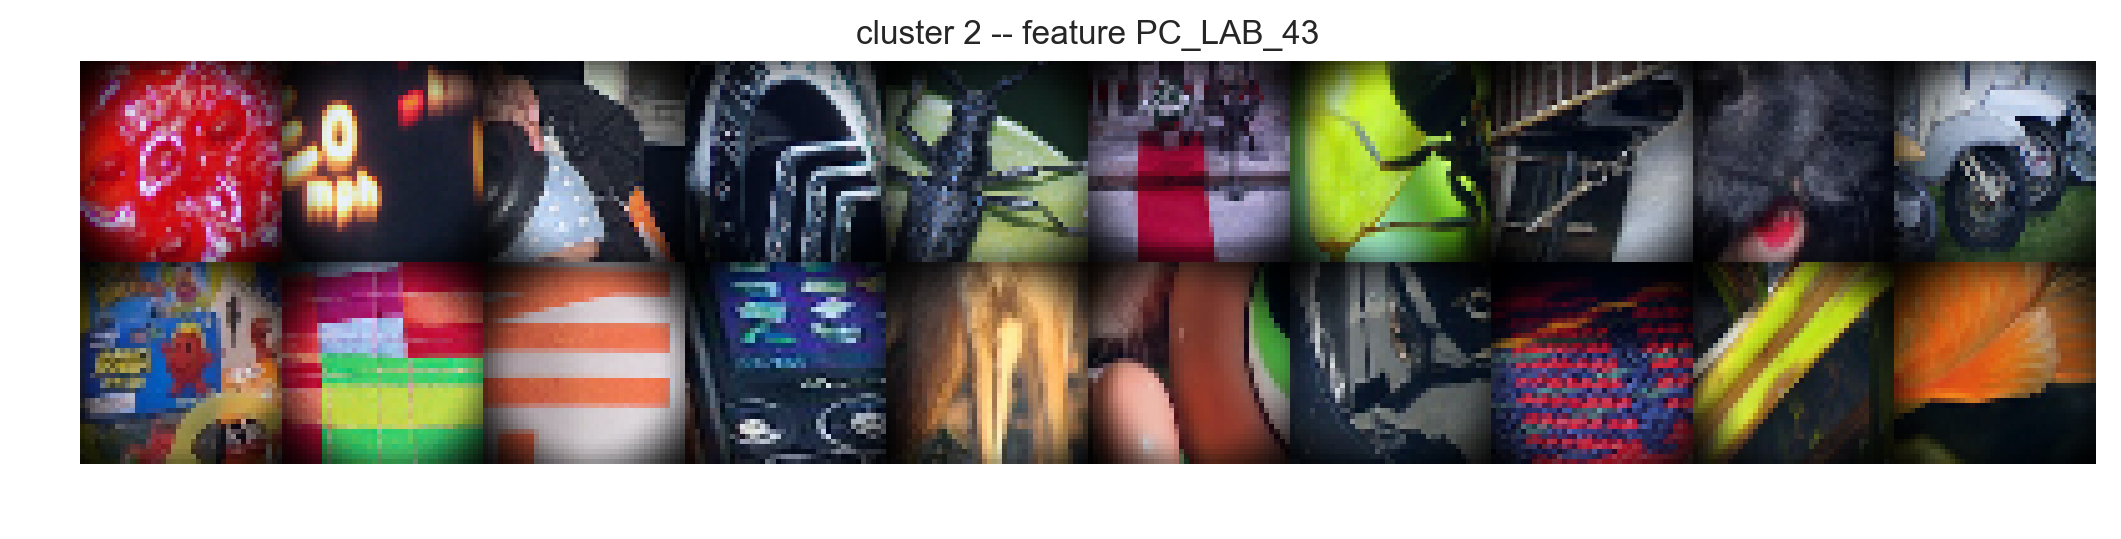

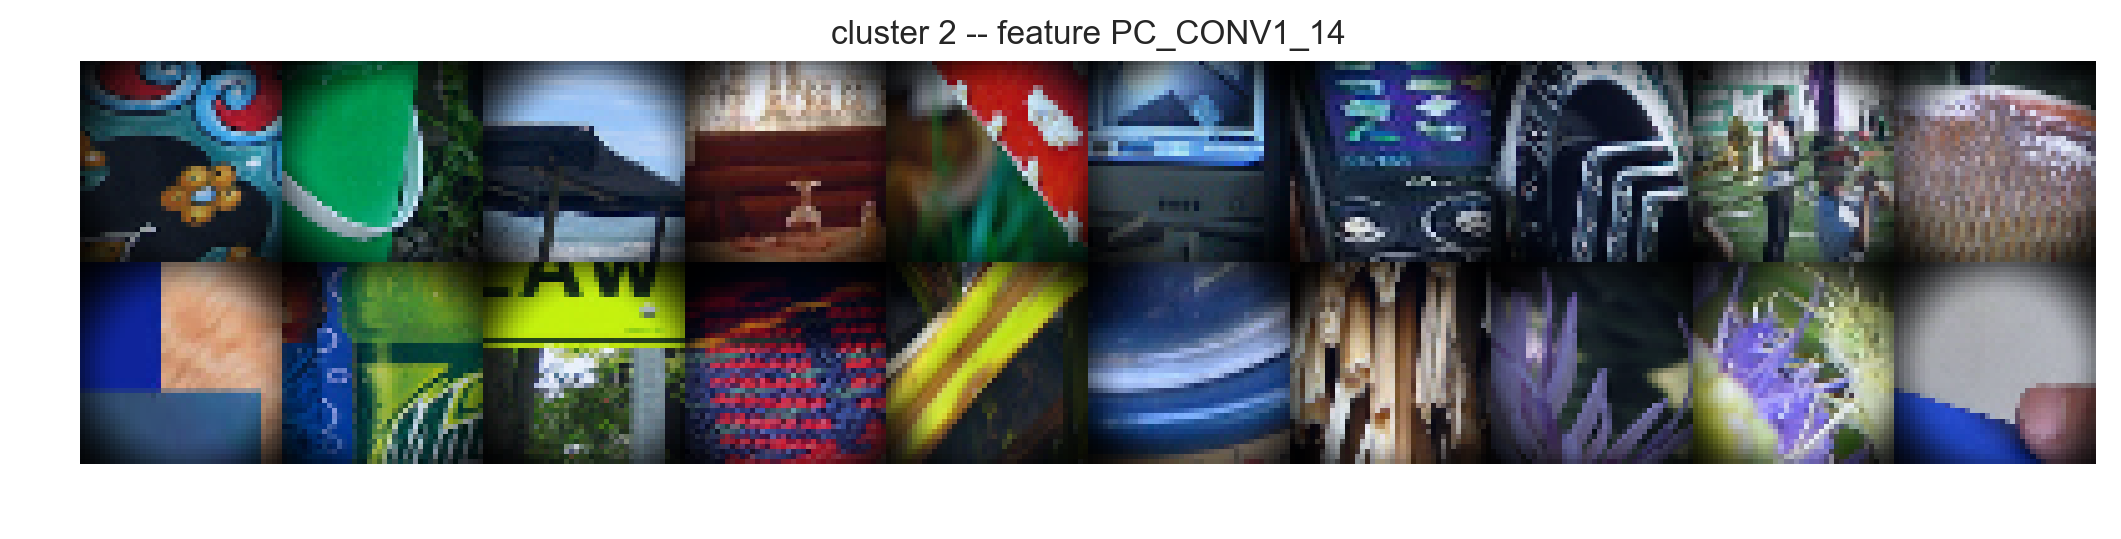

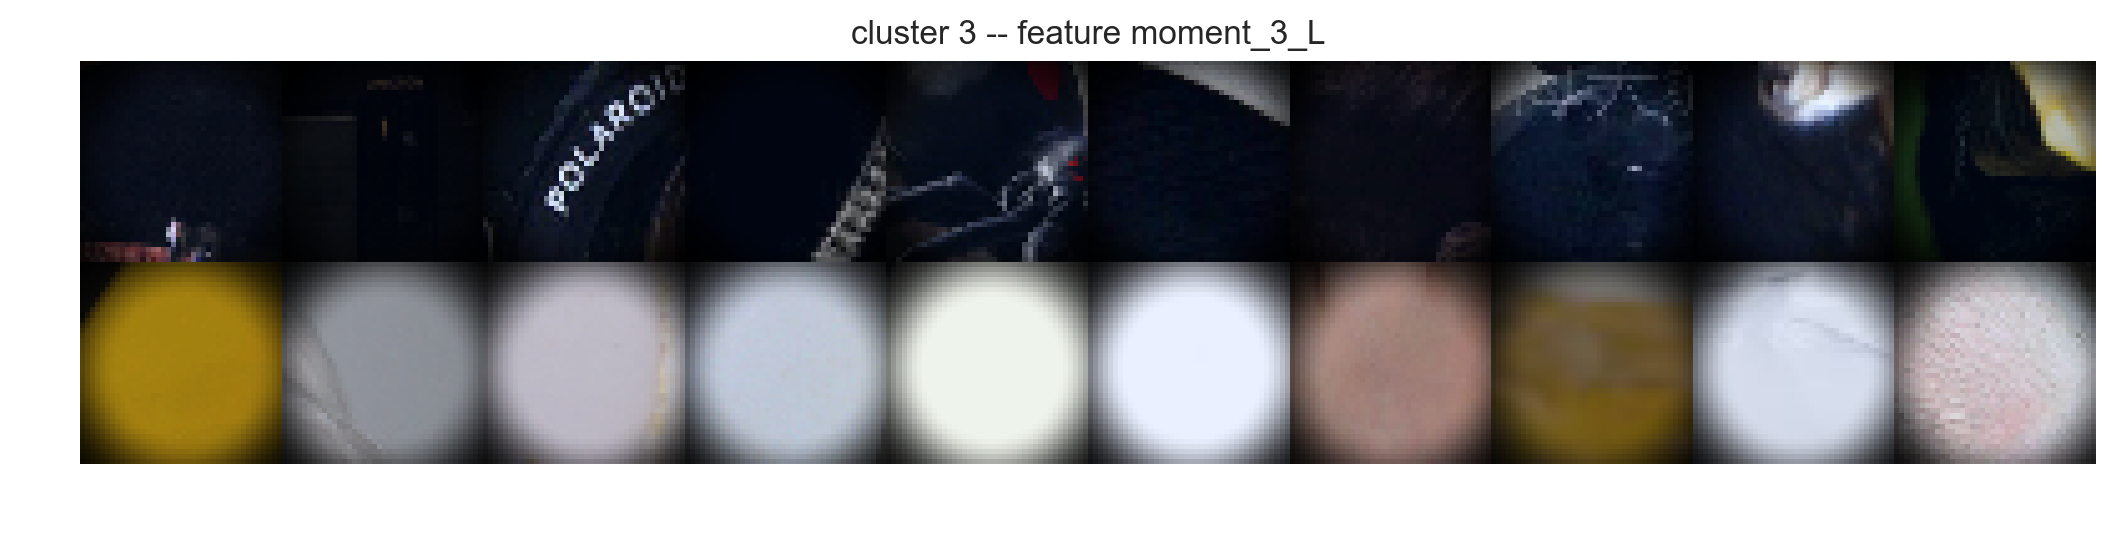

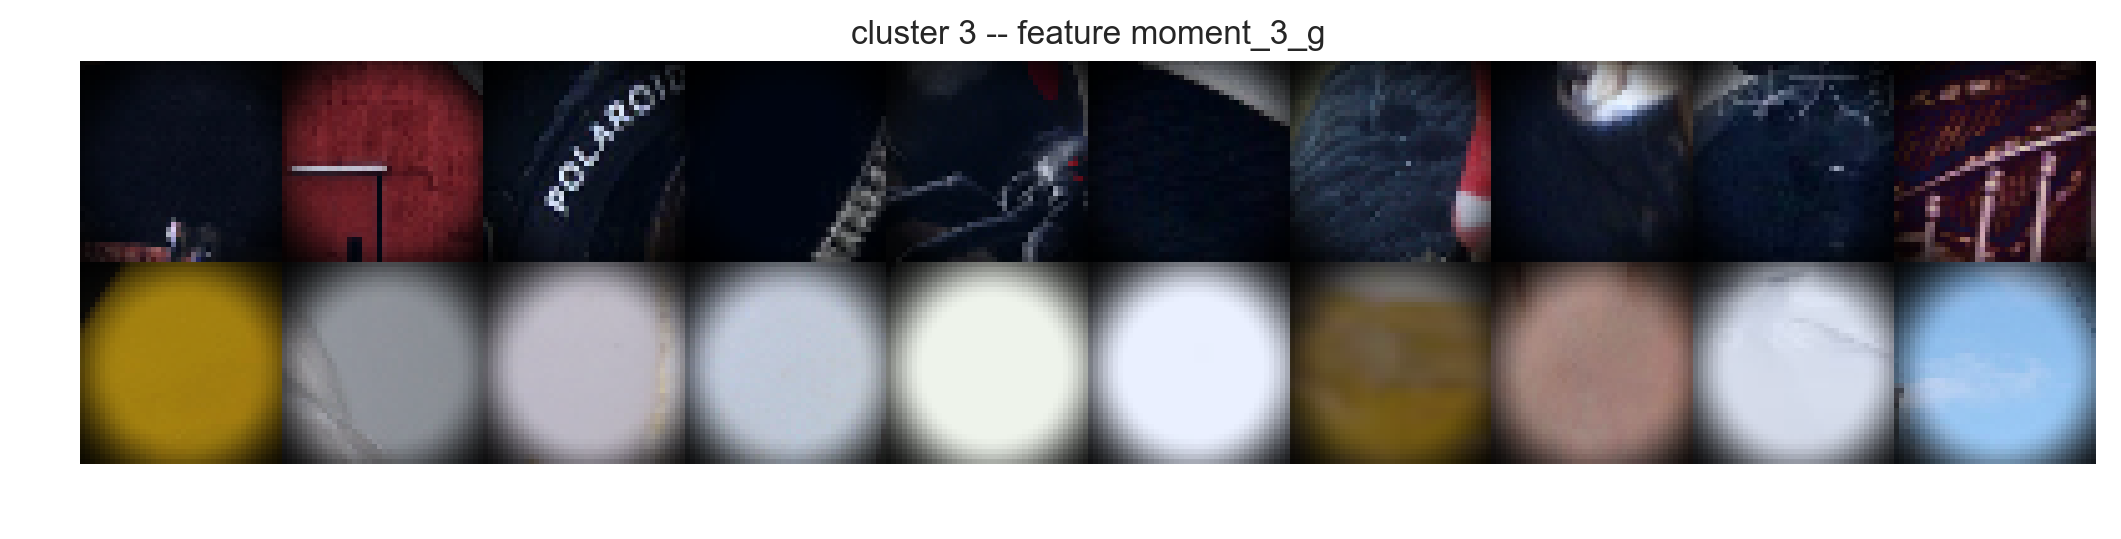

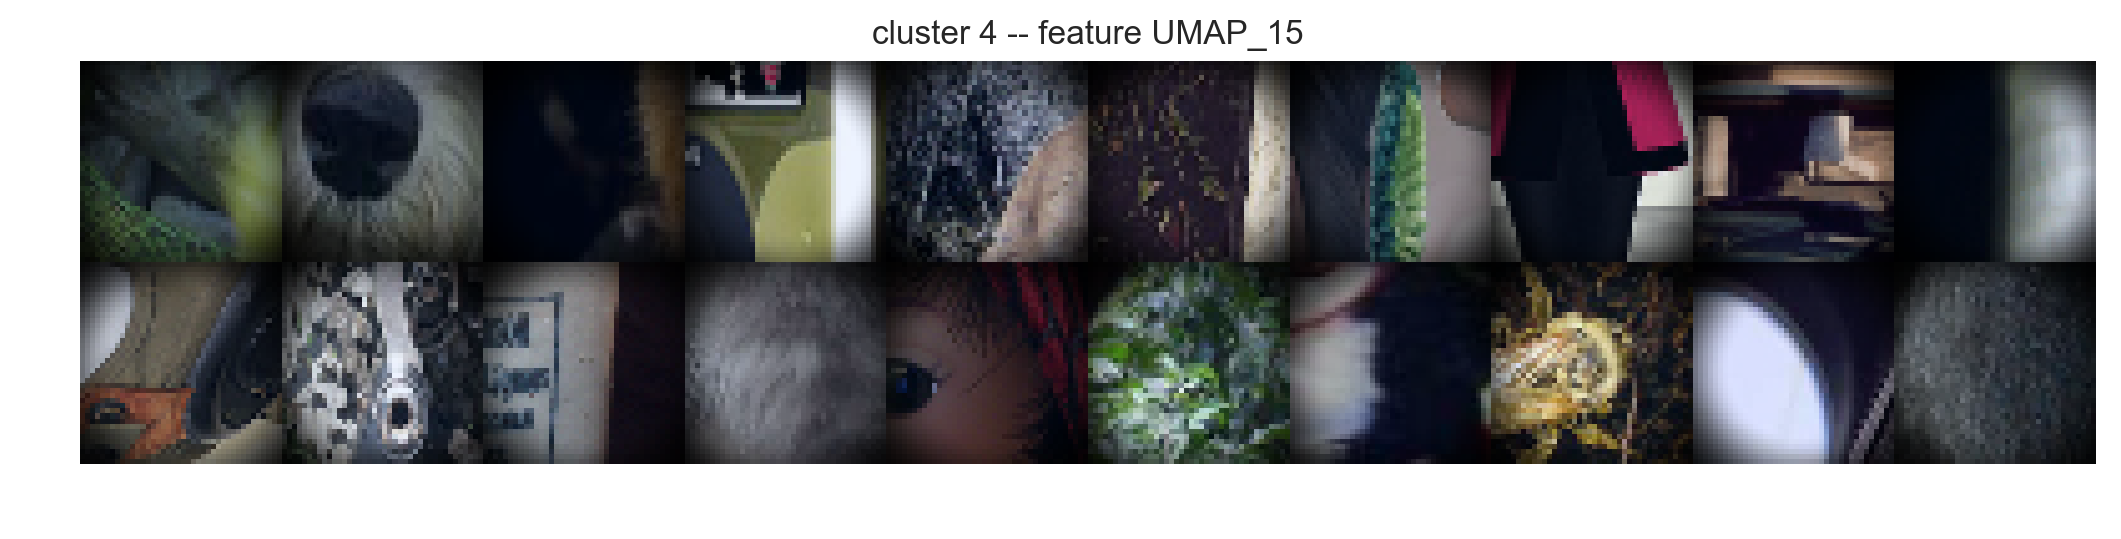

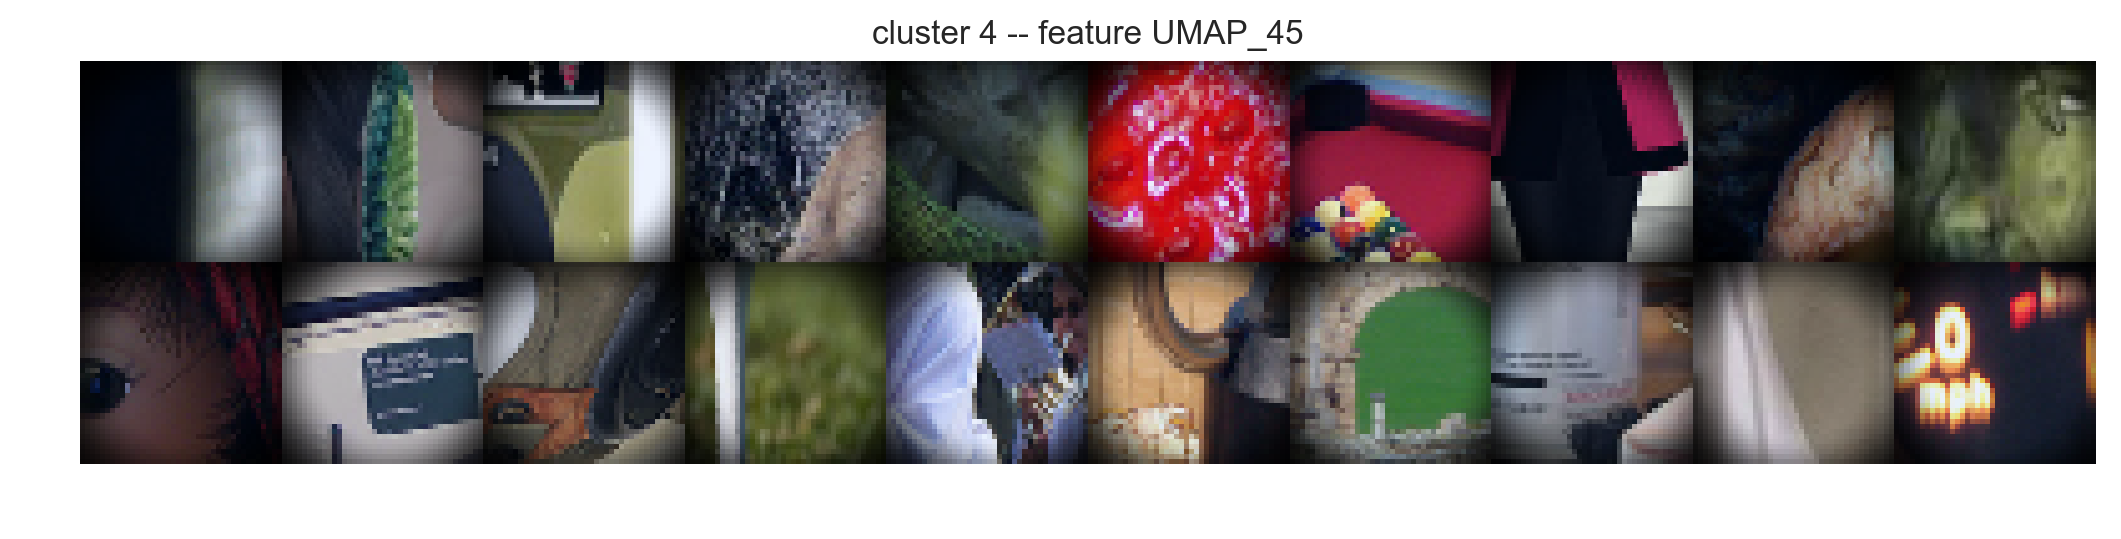

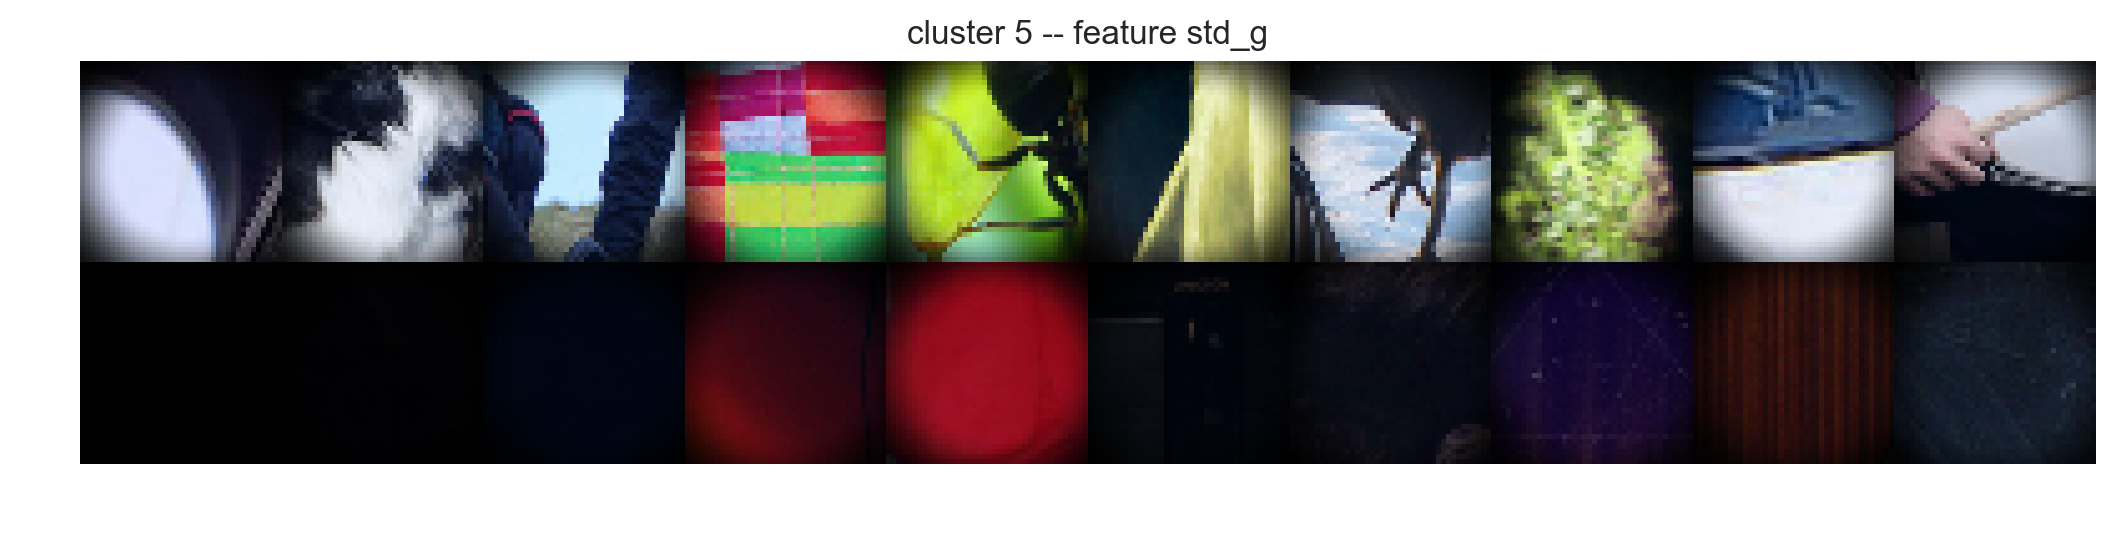

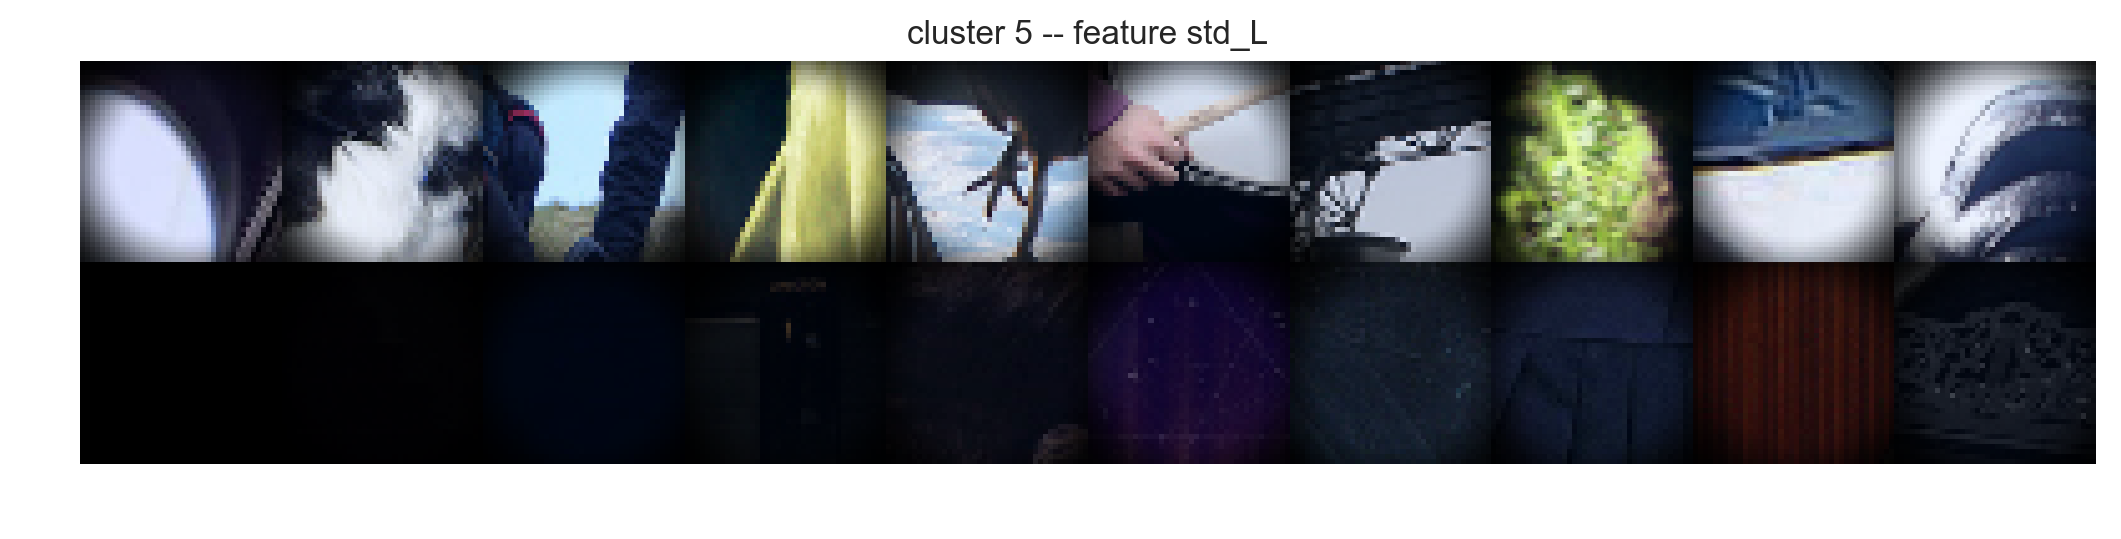

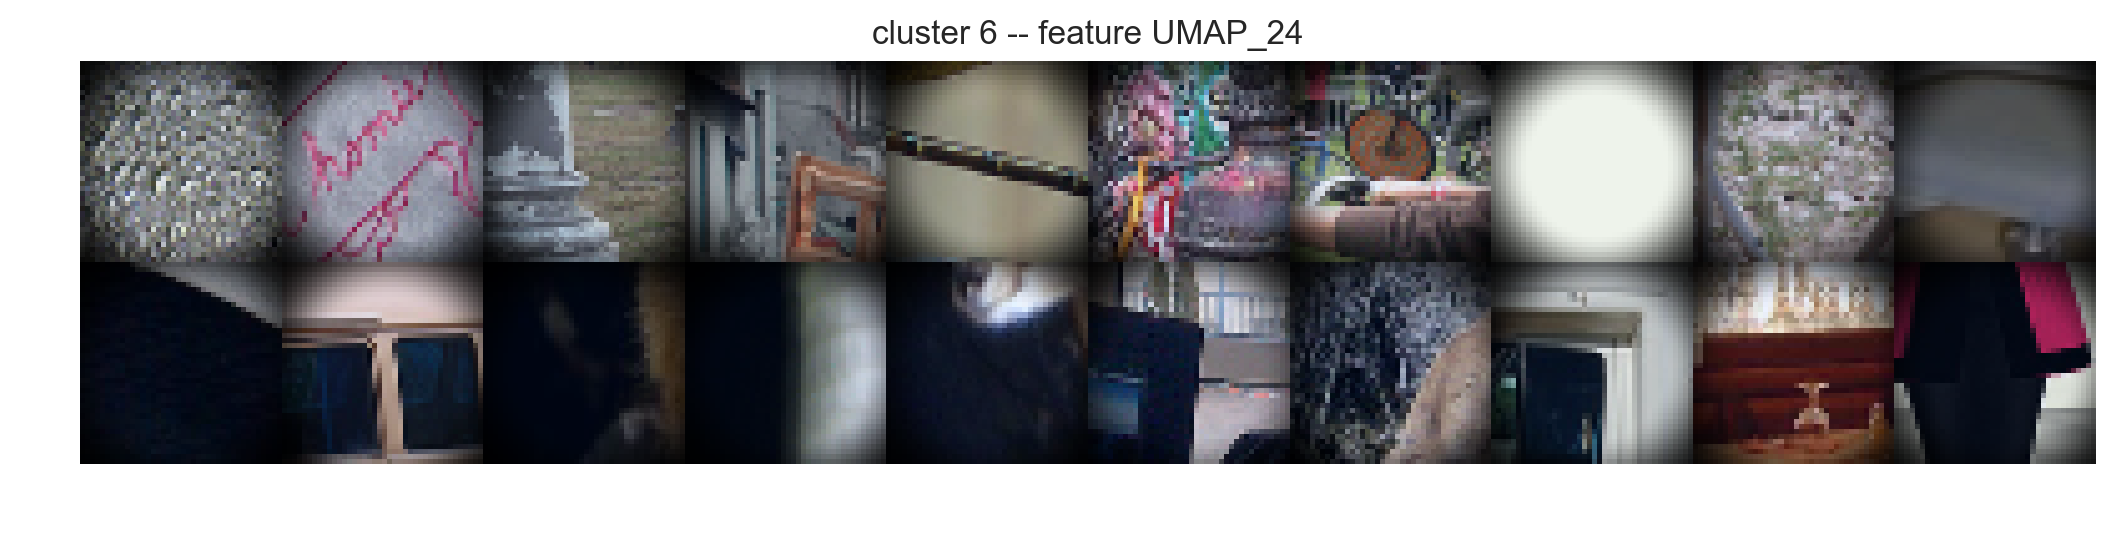

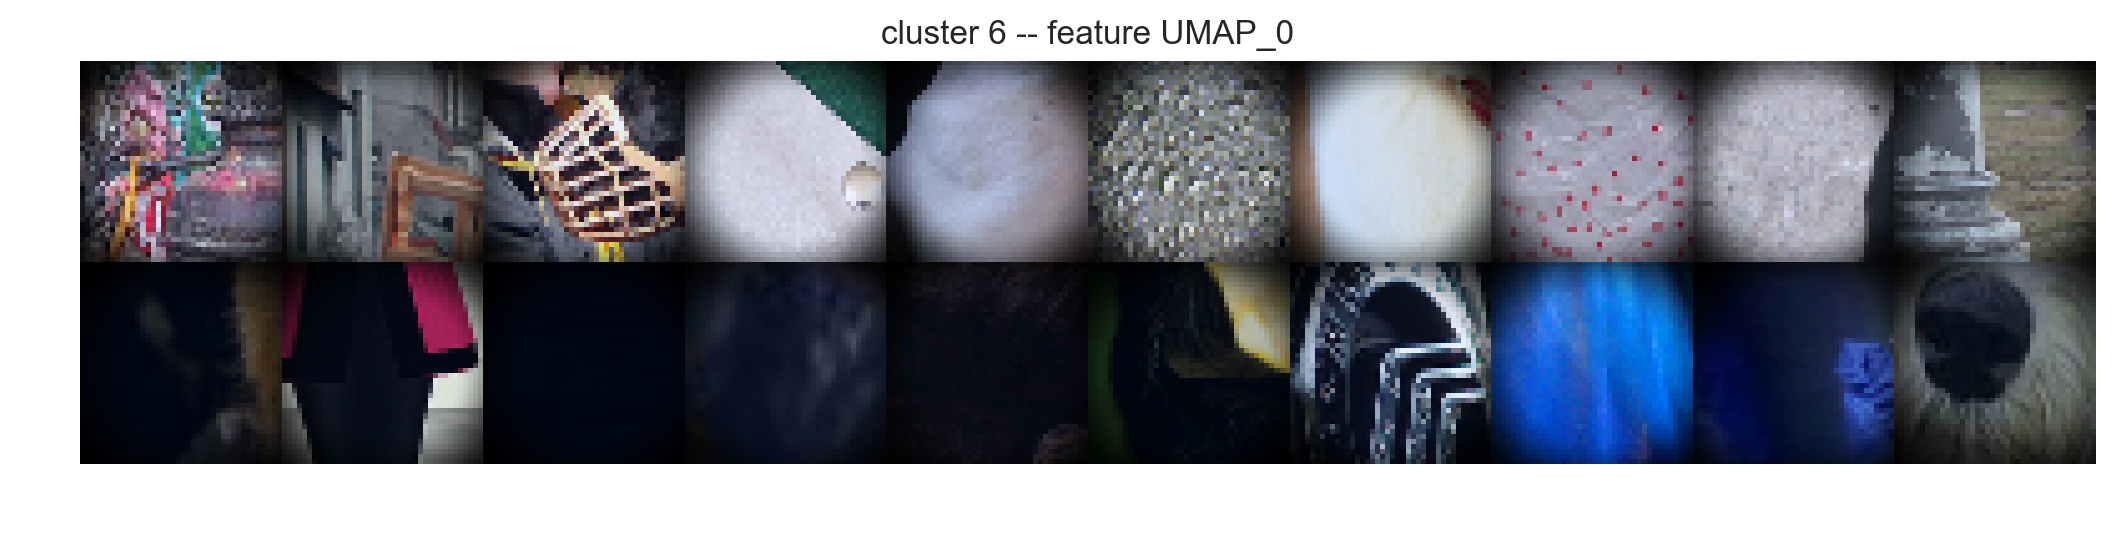

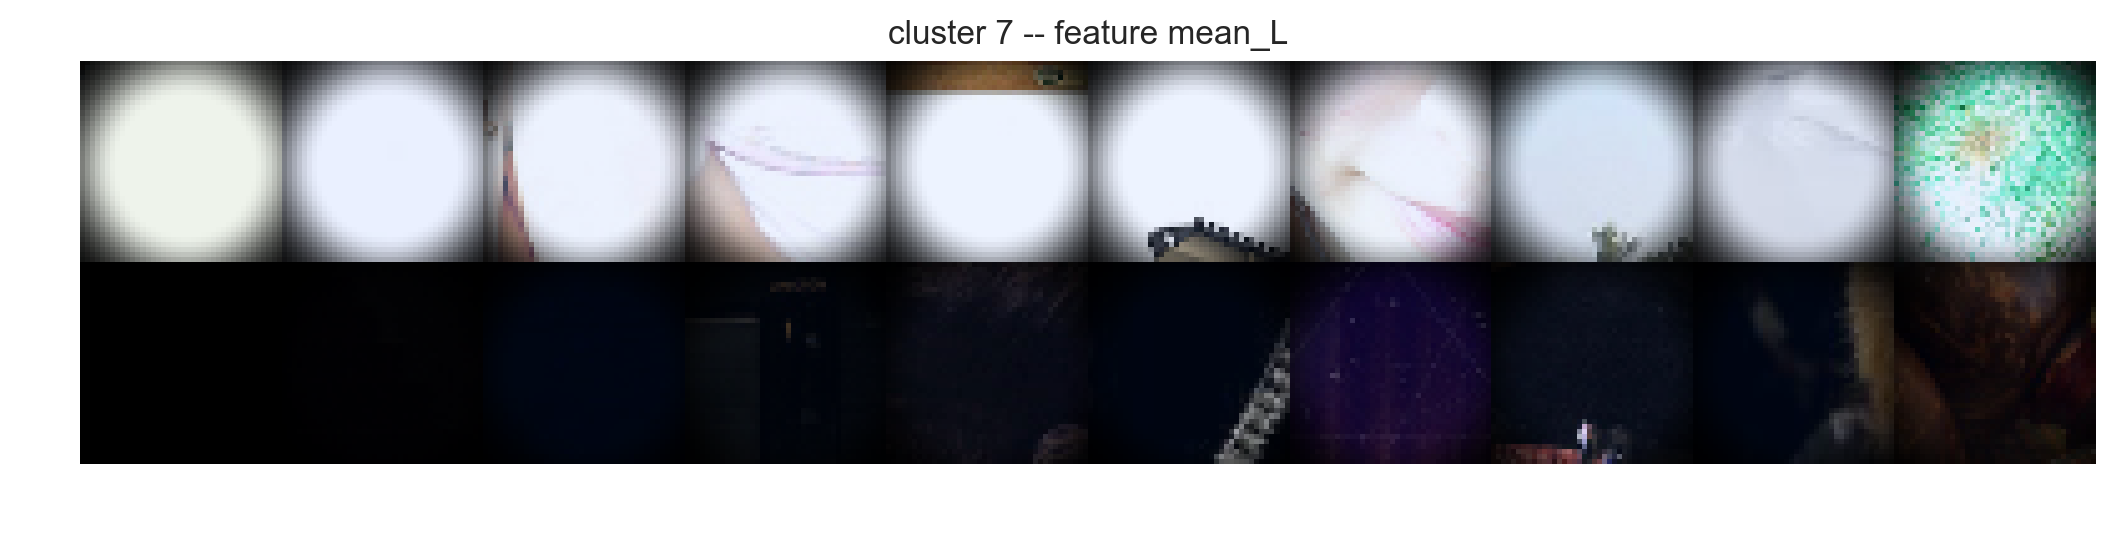

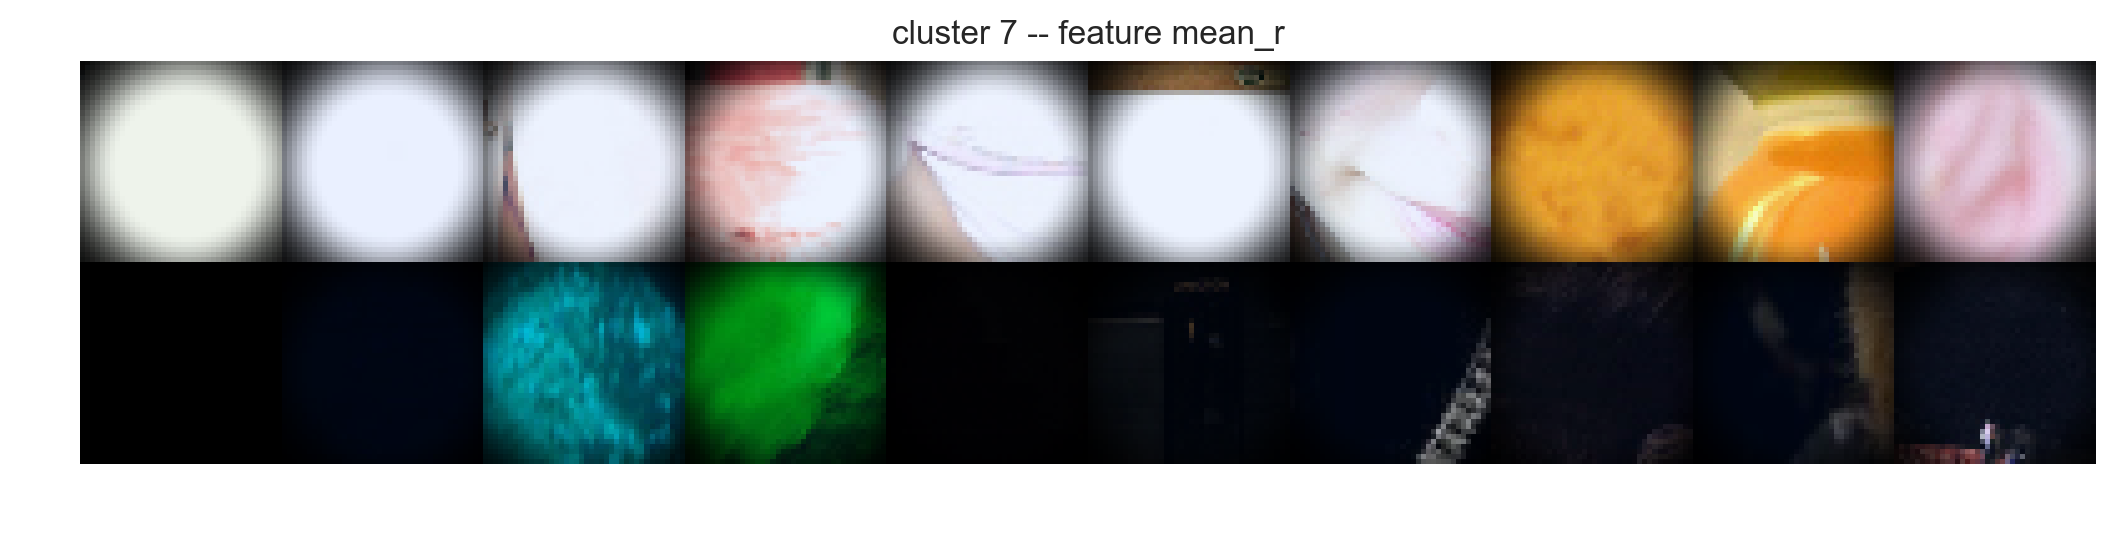

In [27]:
for c in np.unique(clusters):
    check = clusters == c
    summed = np.sum(importances[check,:], axis=0)
    ixs = np.argsort(-summed)[:2]

    for ix in ixs:
        vals = X_all[:, ix]
        figure()
        visualize_feature(images, vals)
        title('cluster {} -- feature {}'.format(c, names[ix]))

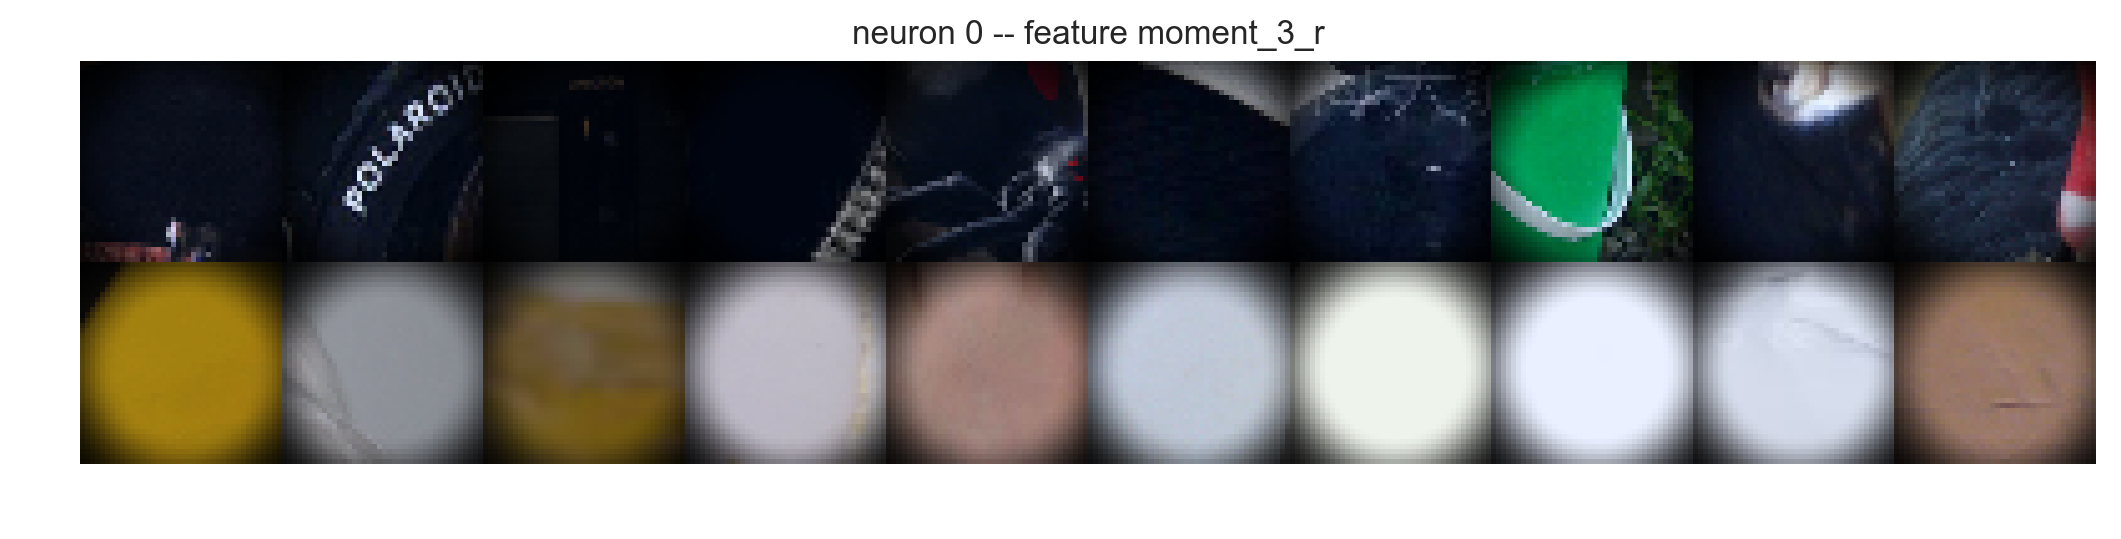

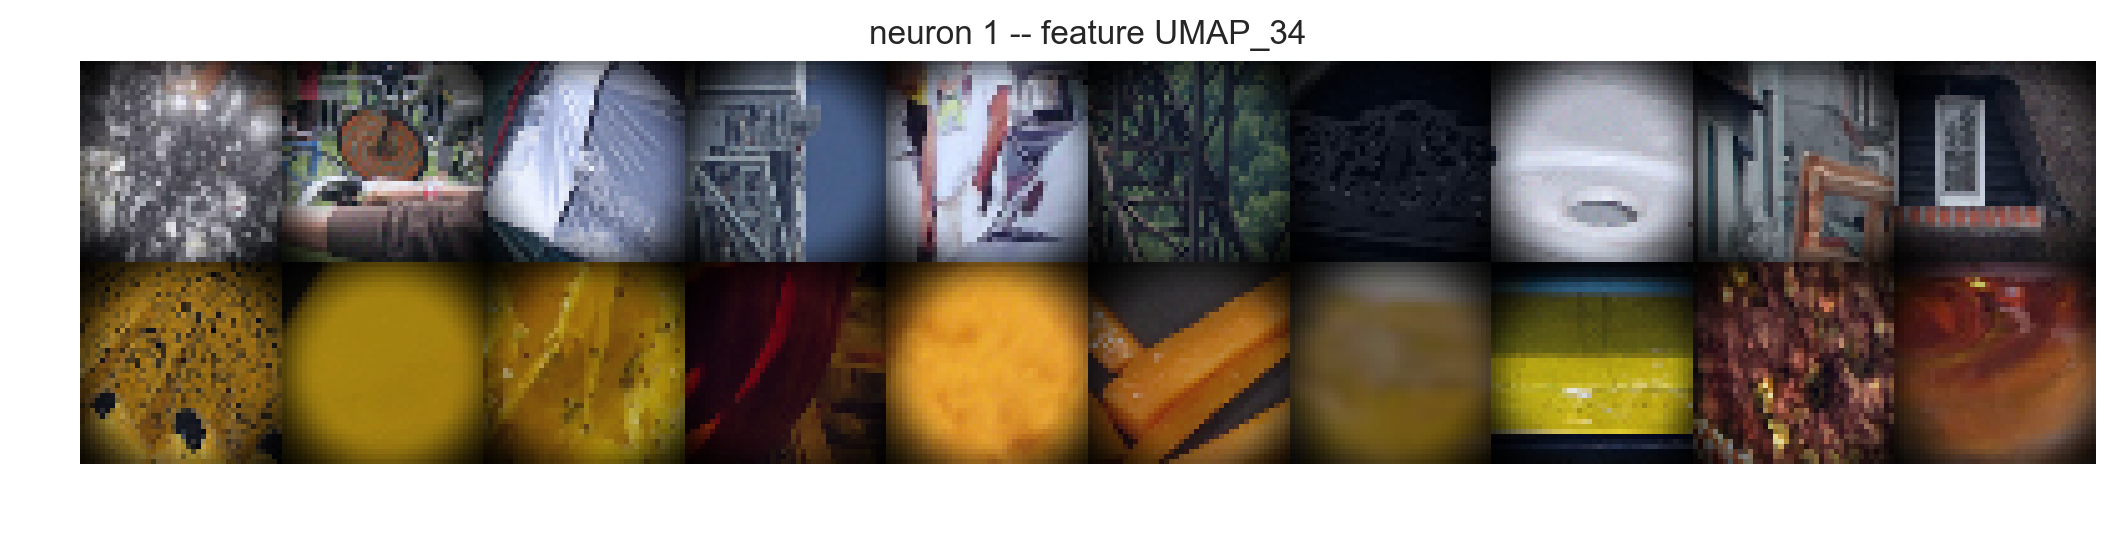

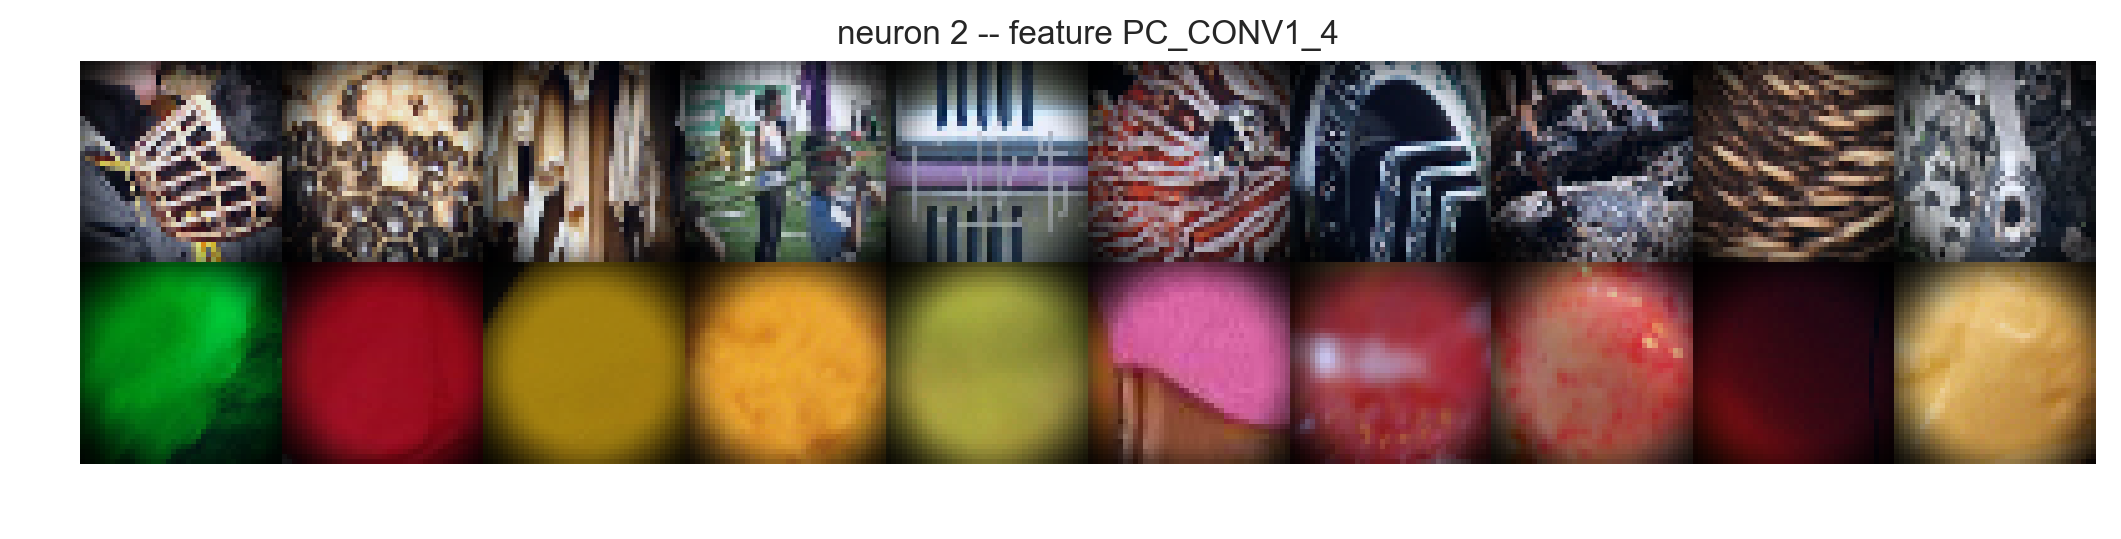

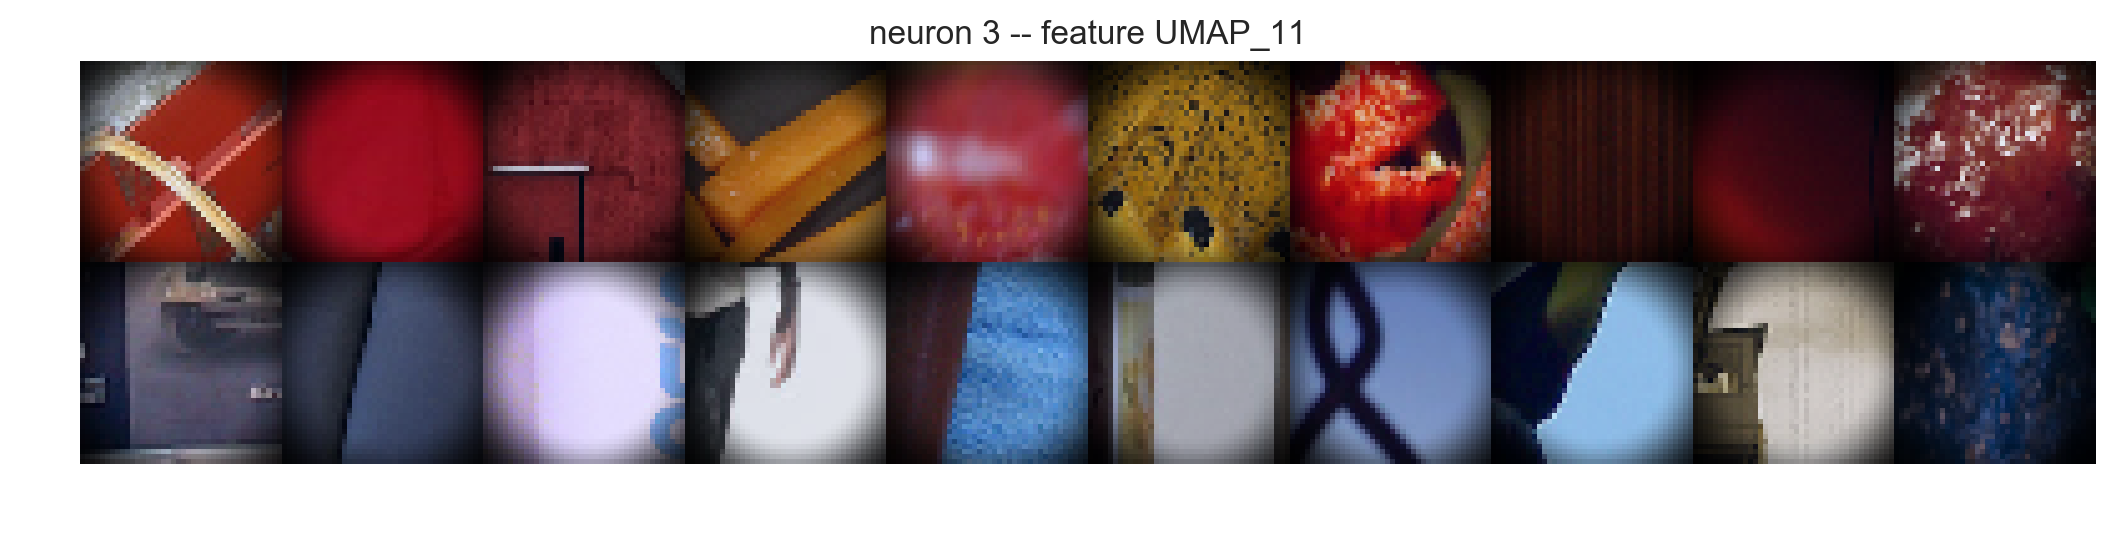

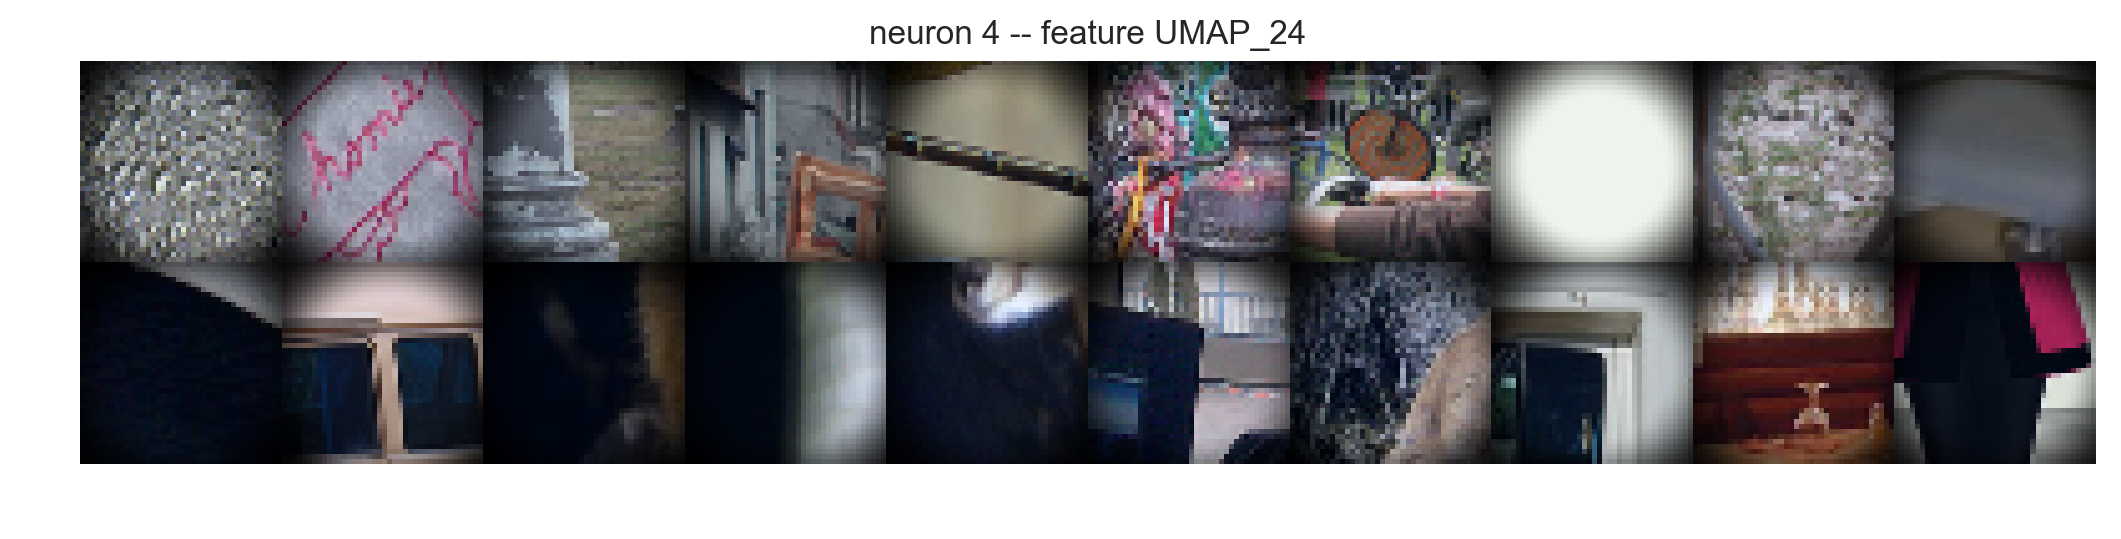

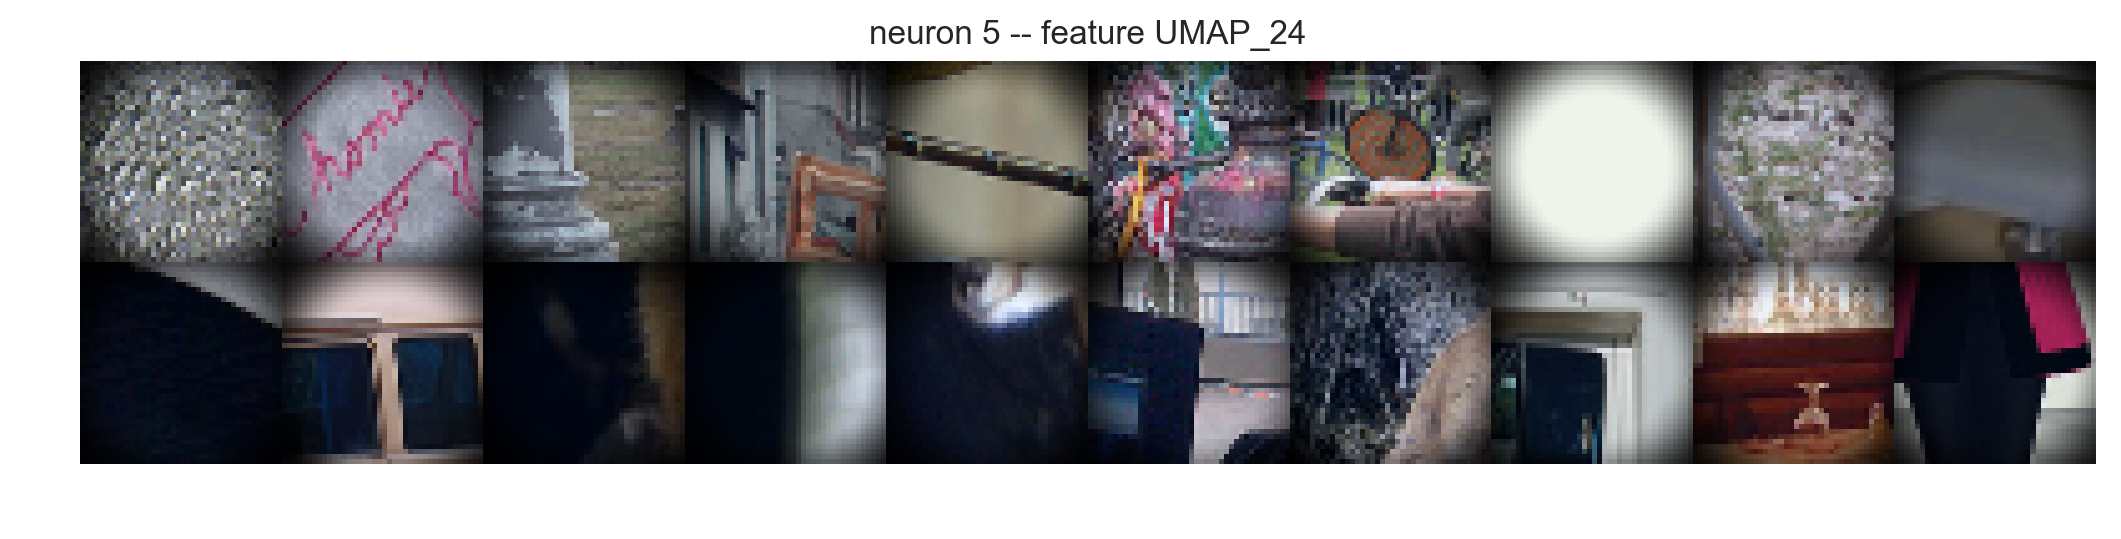

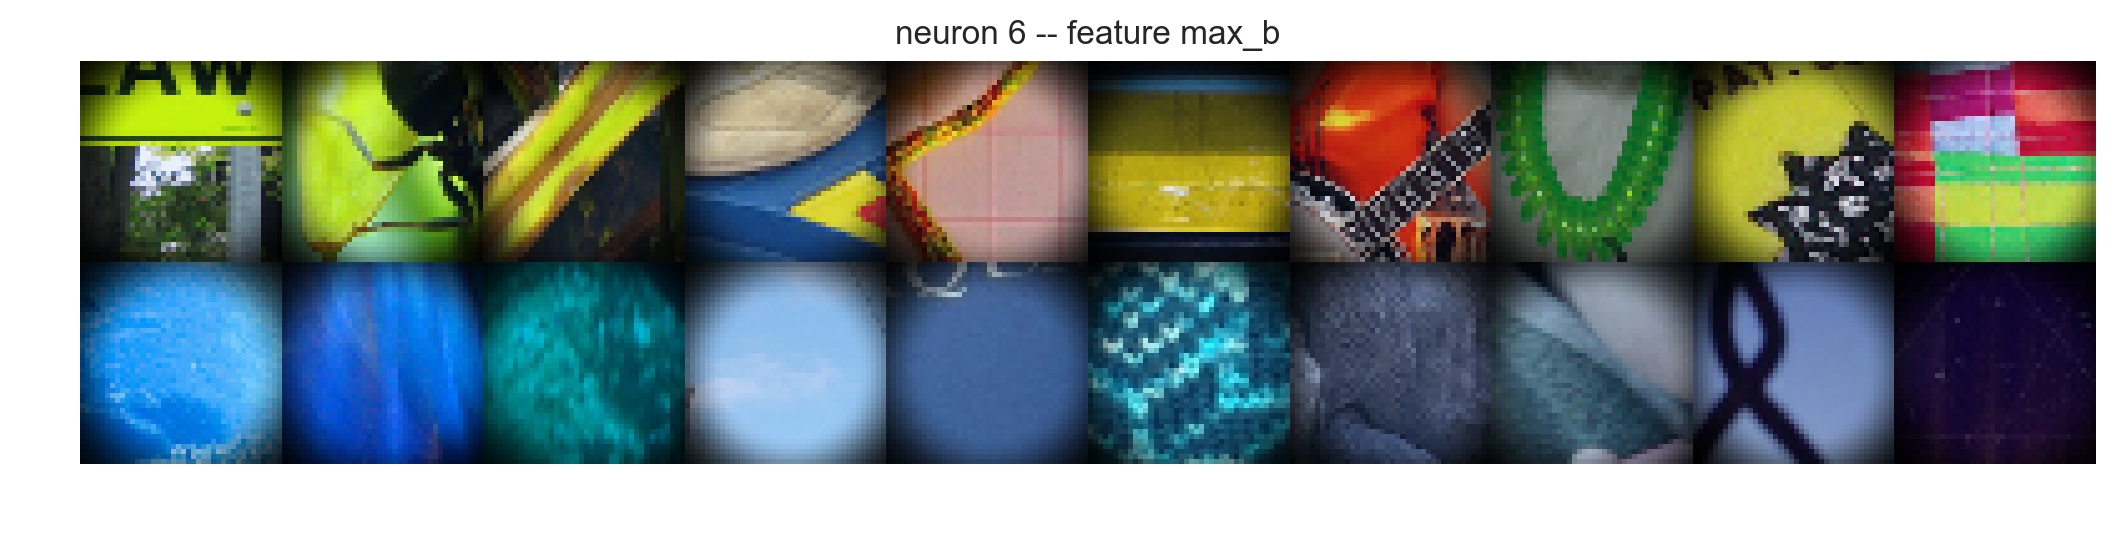

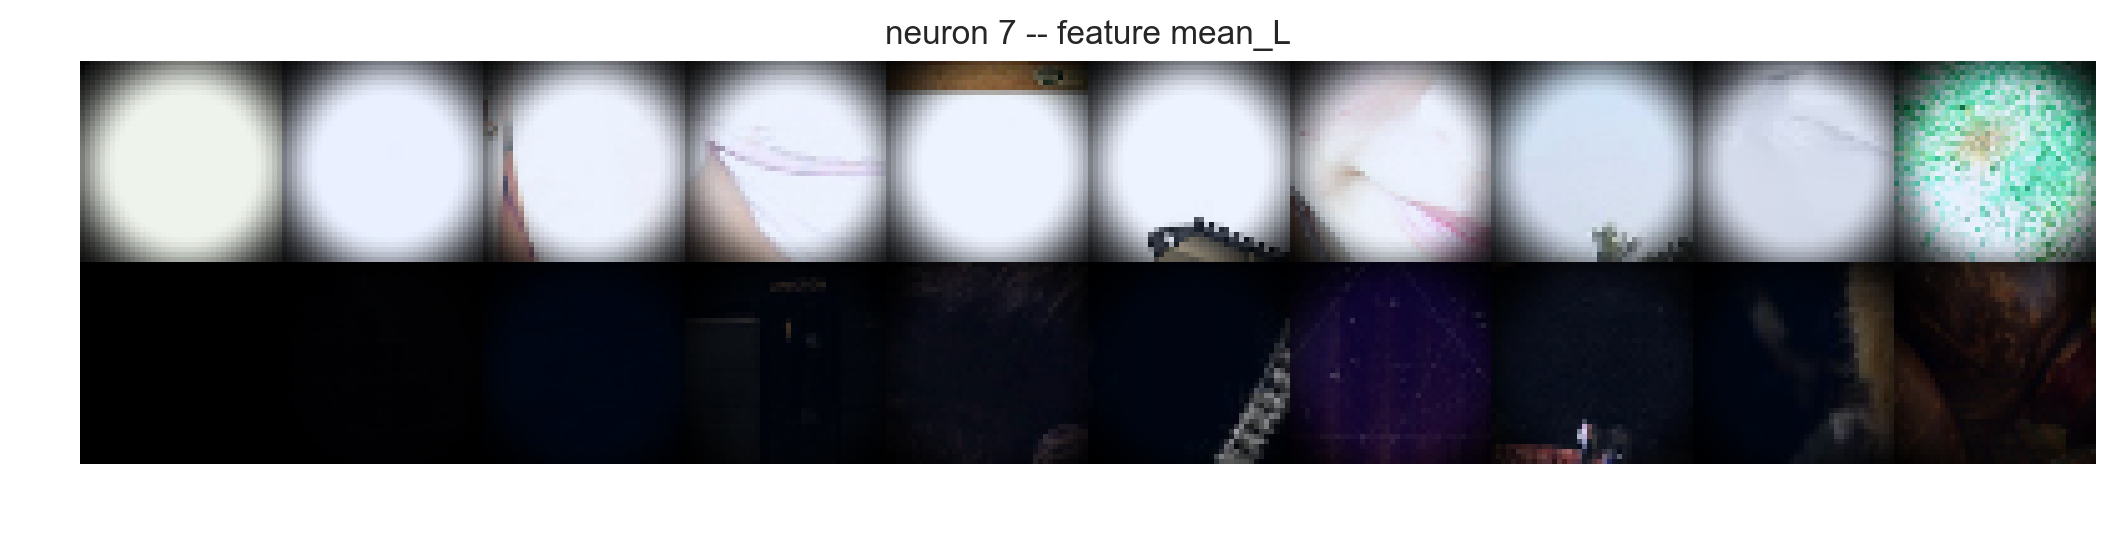

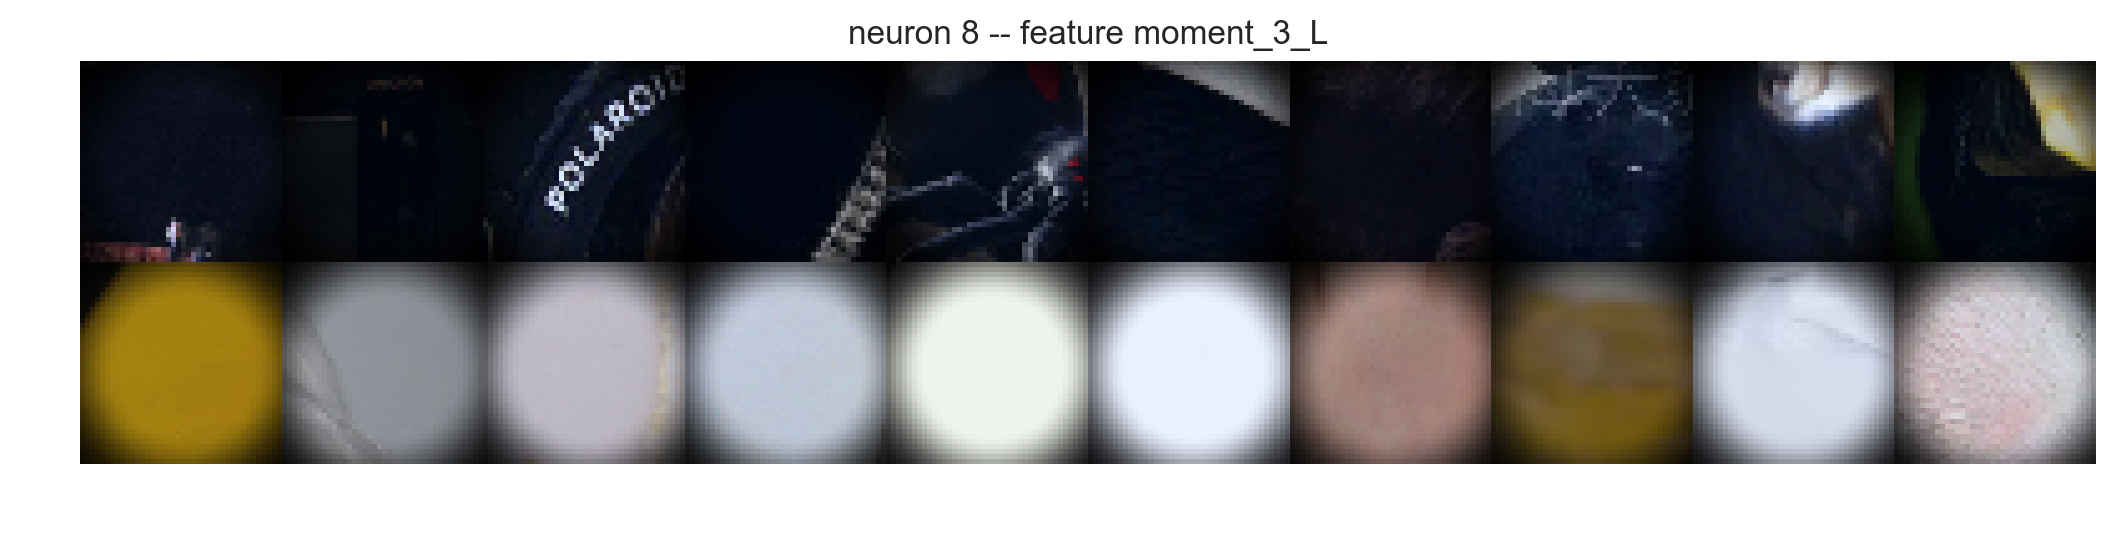

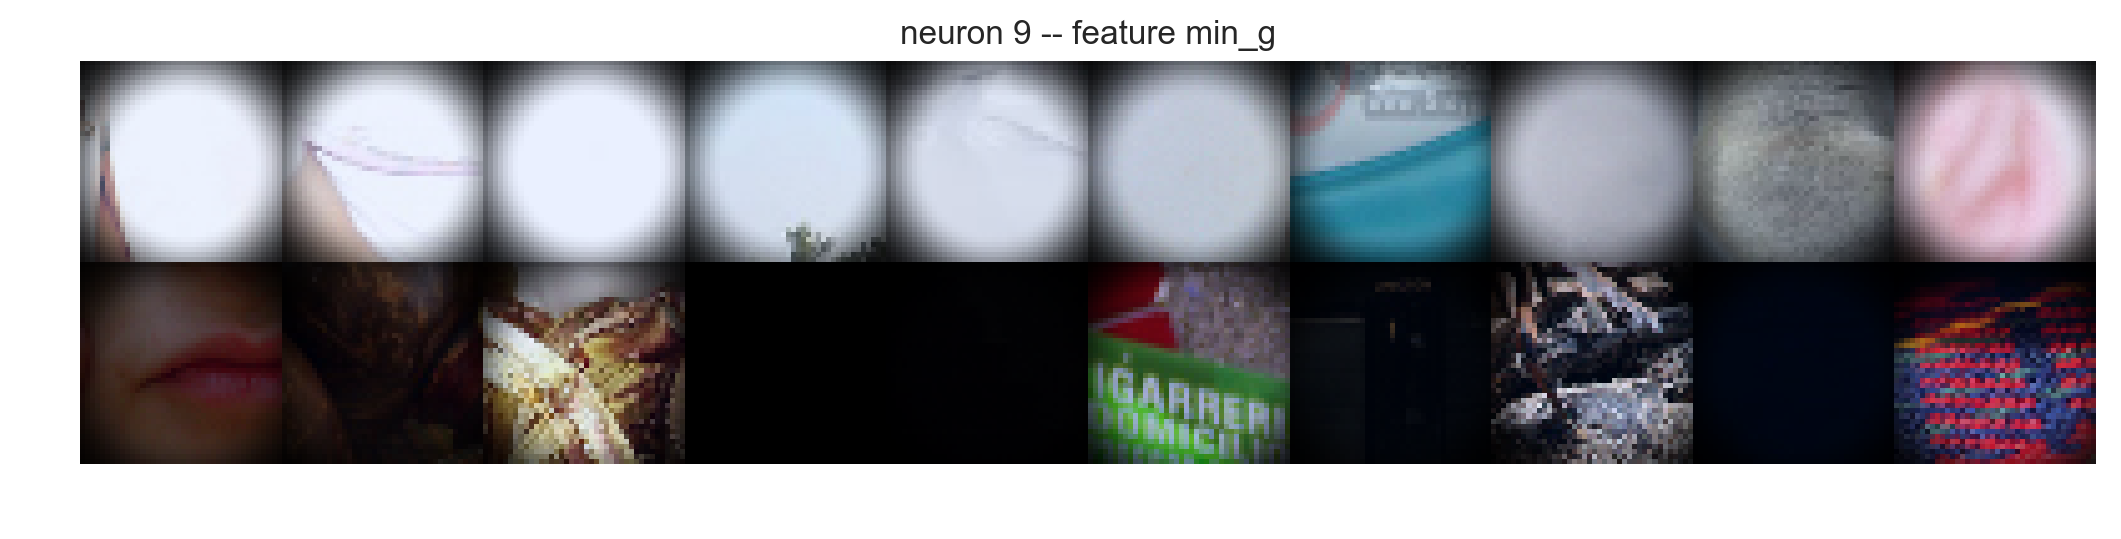

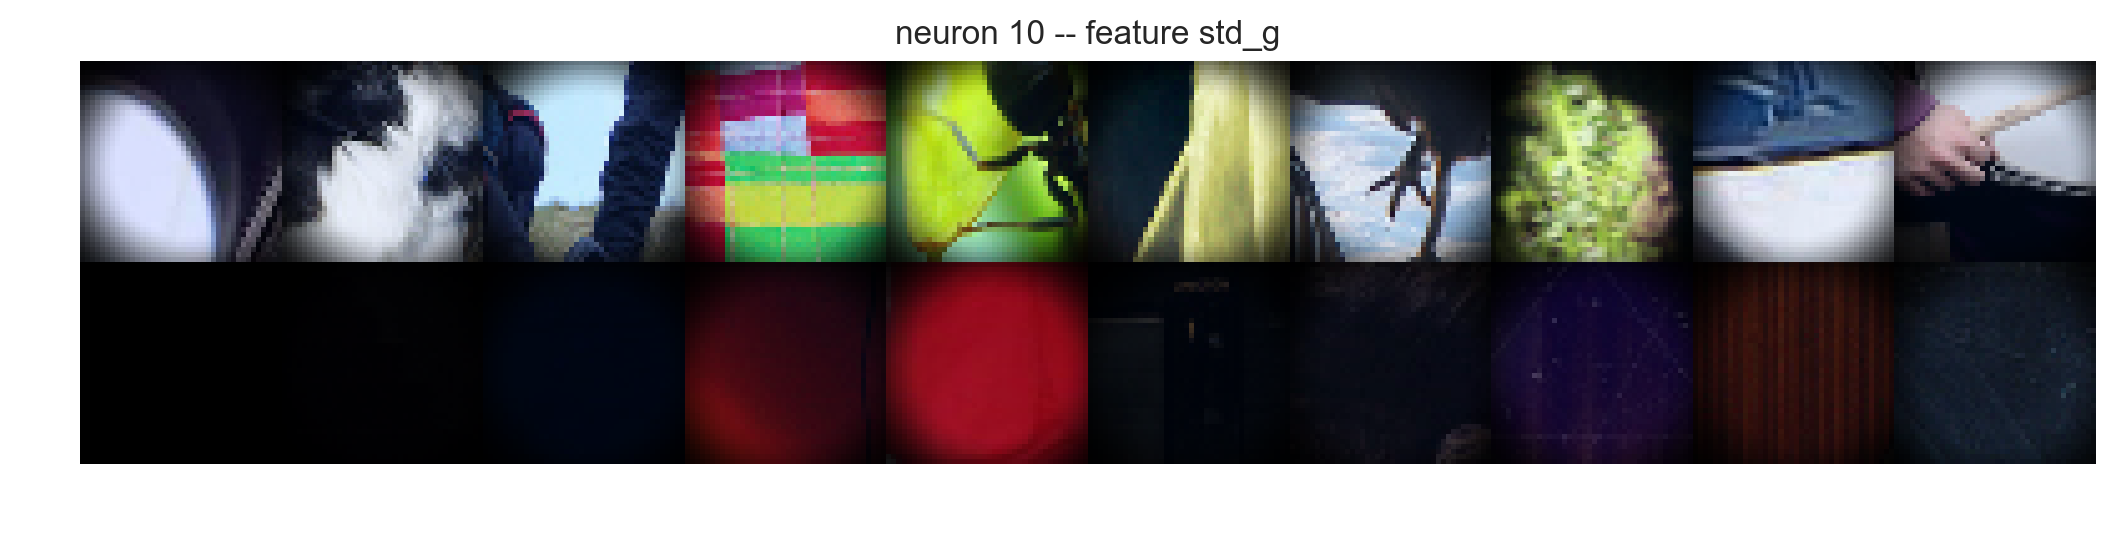

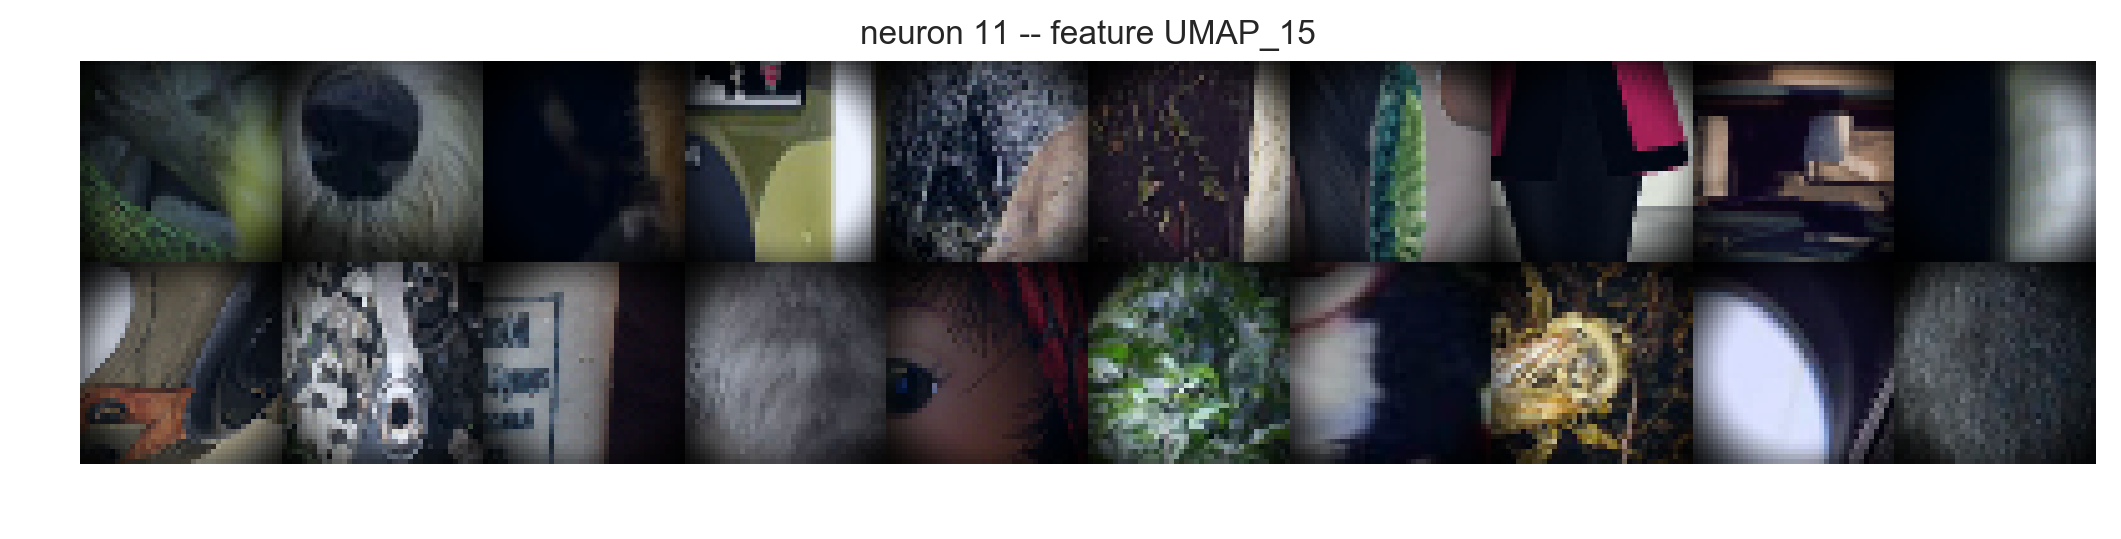

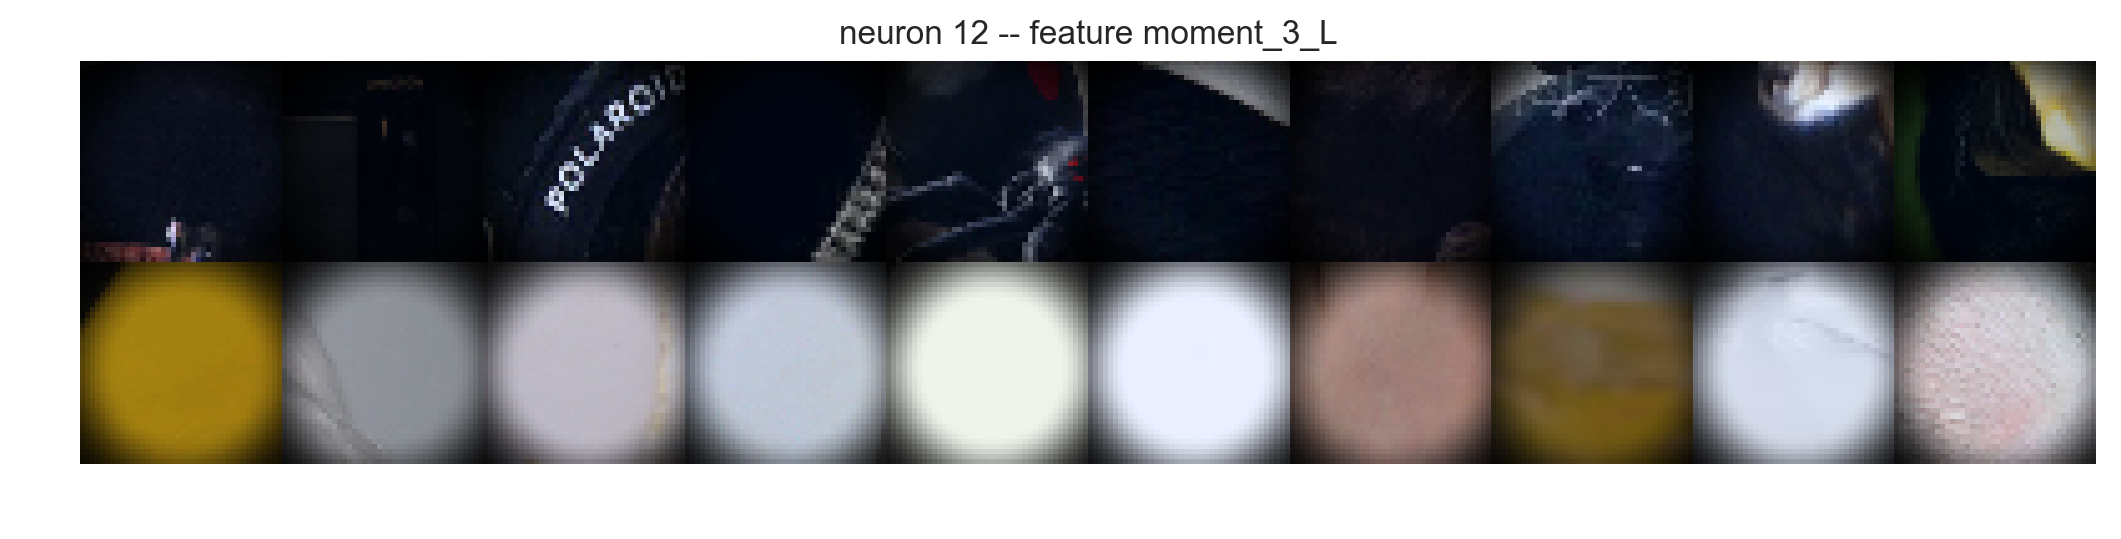

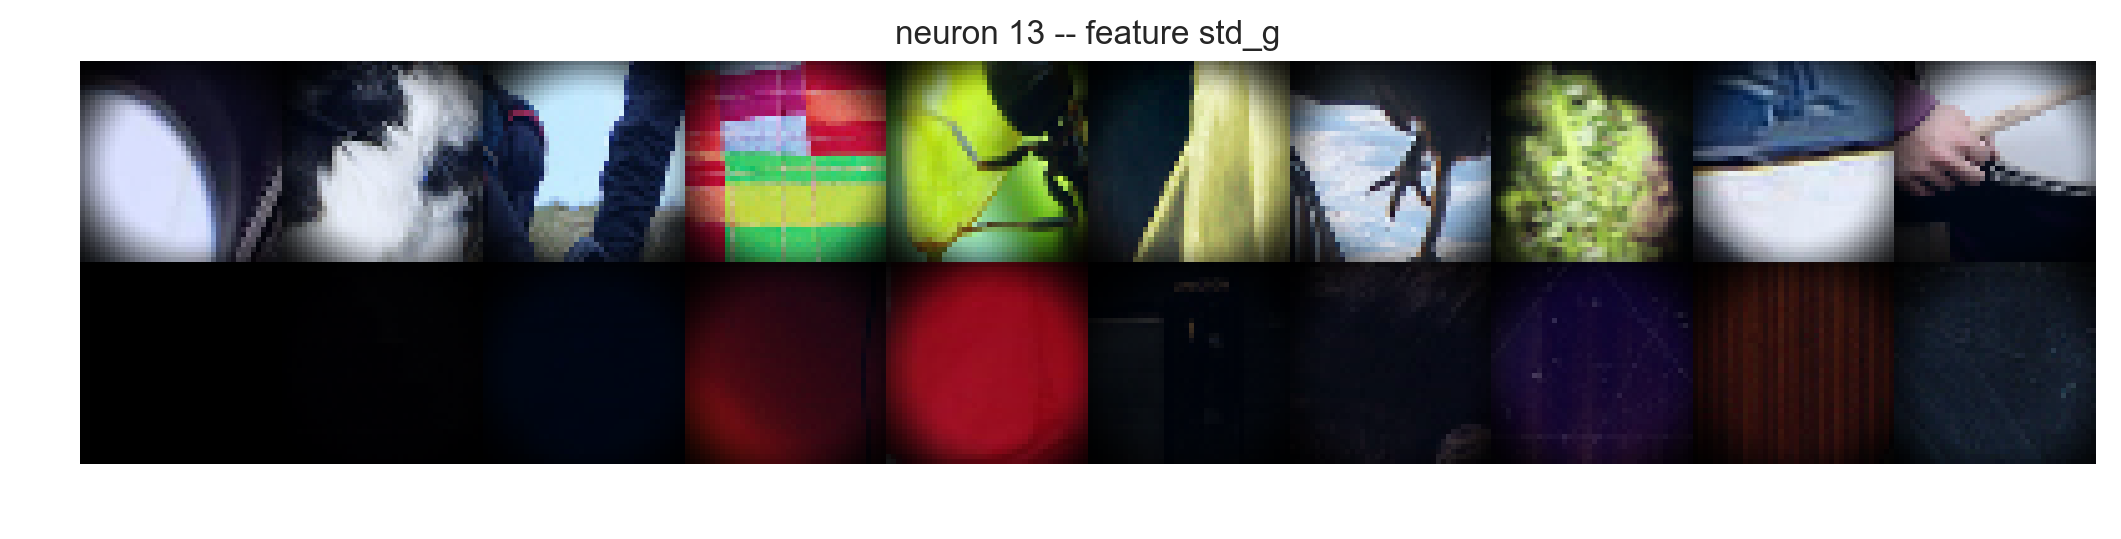

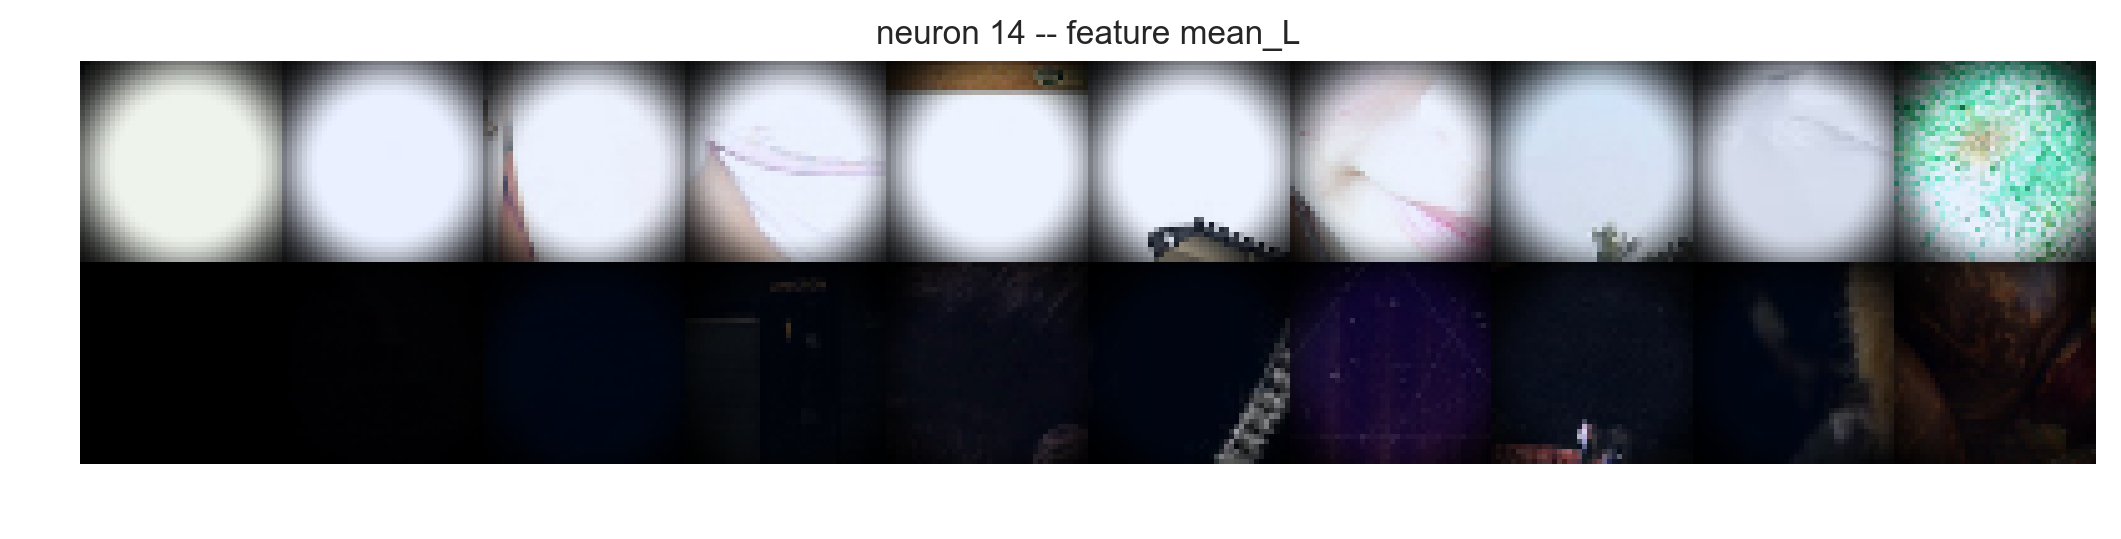

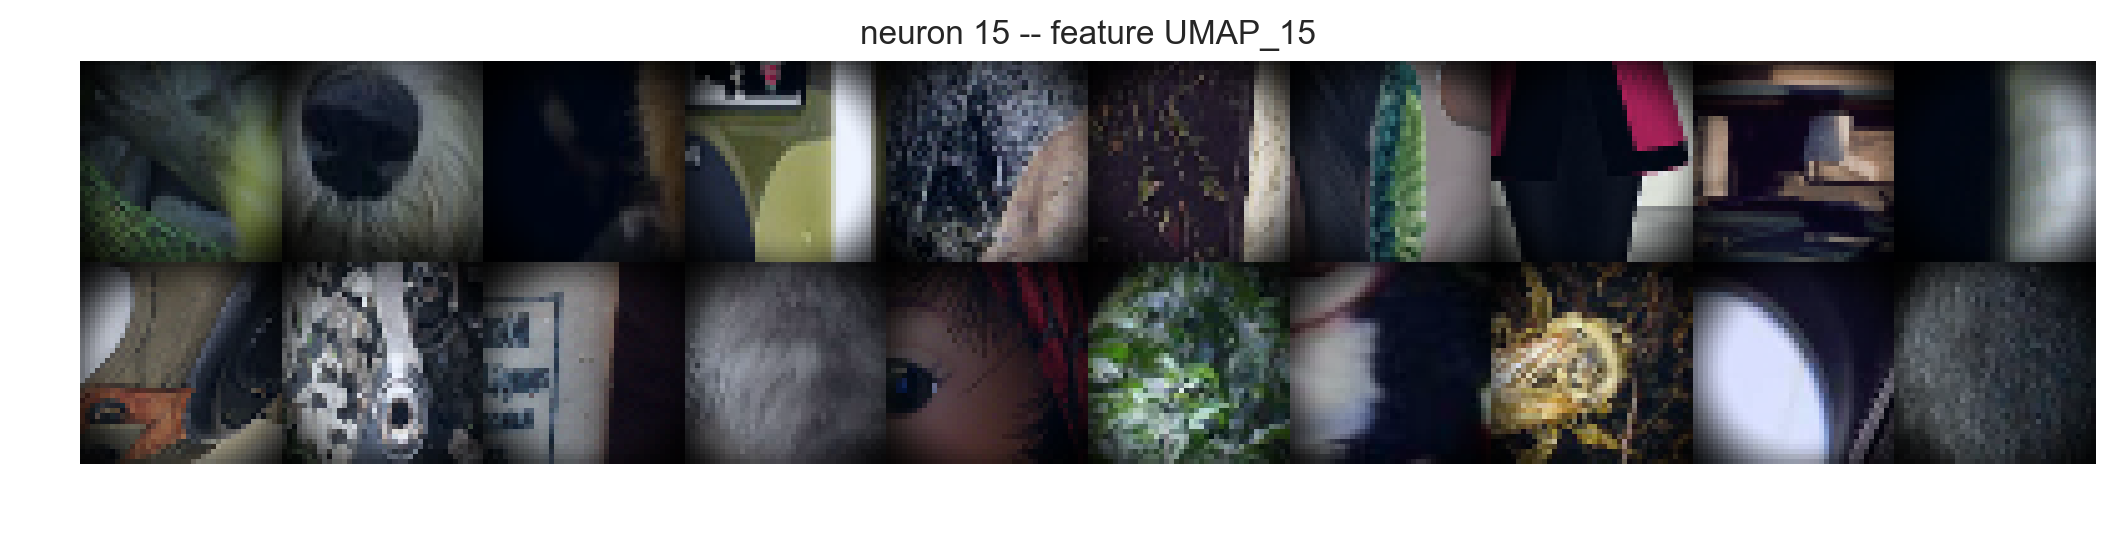

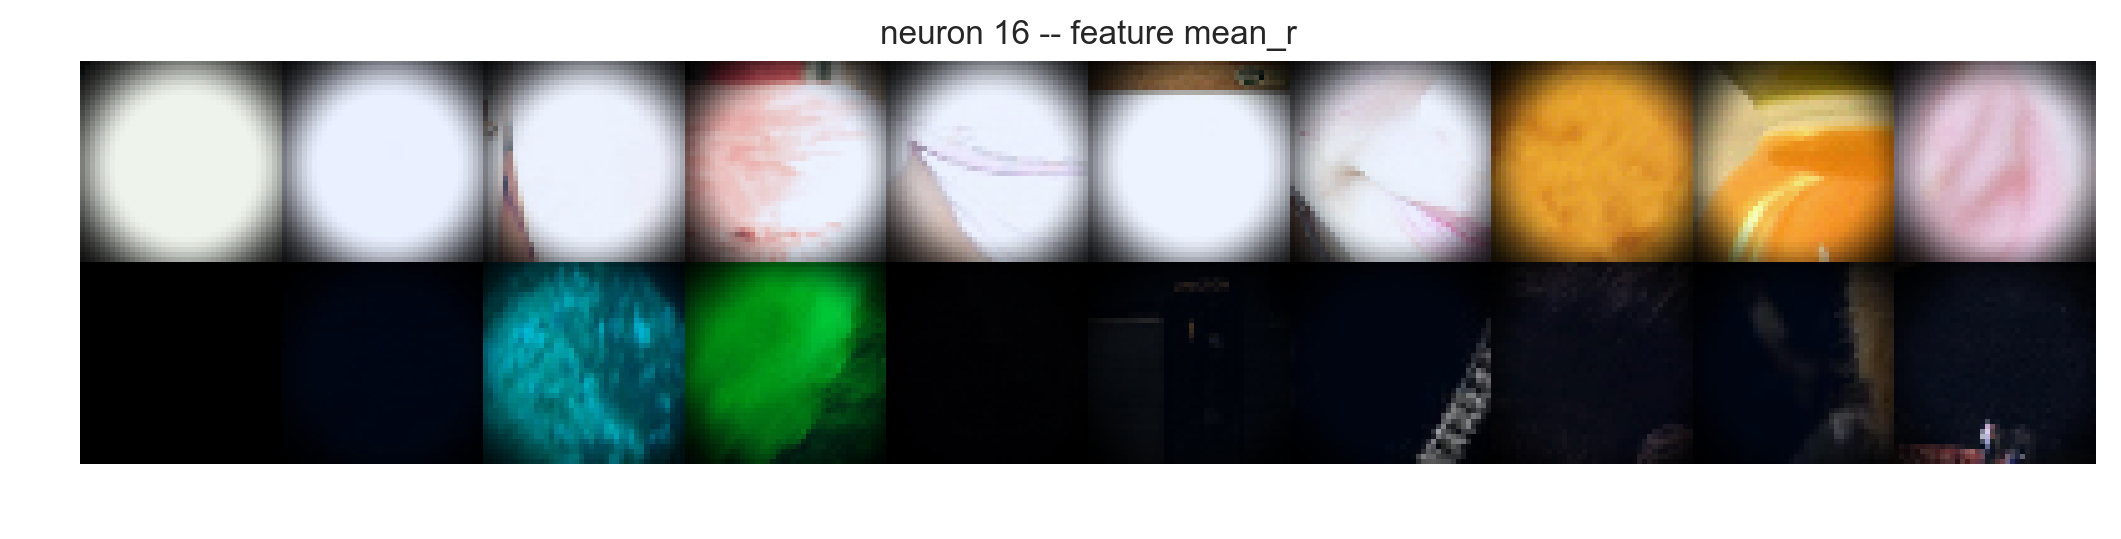

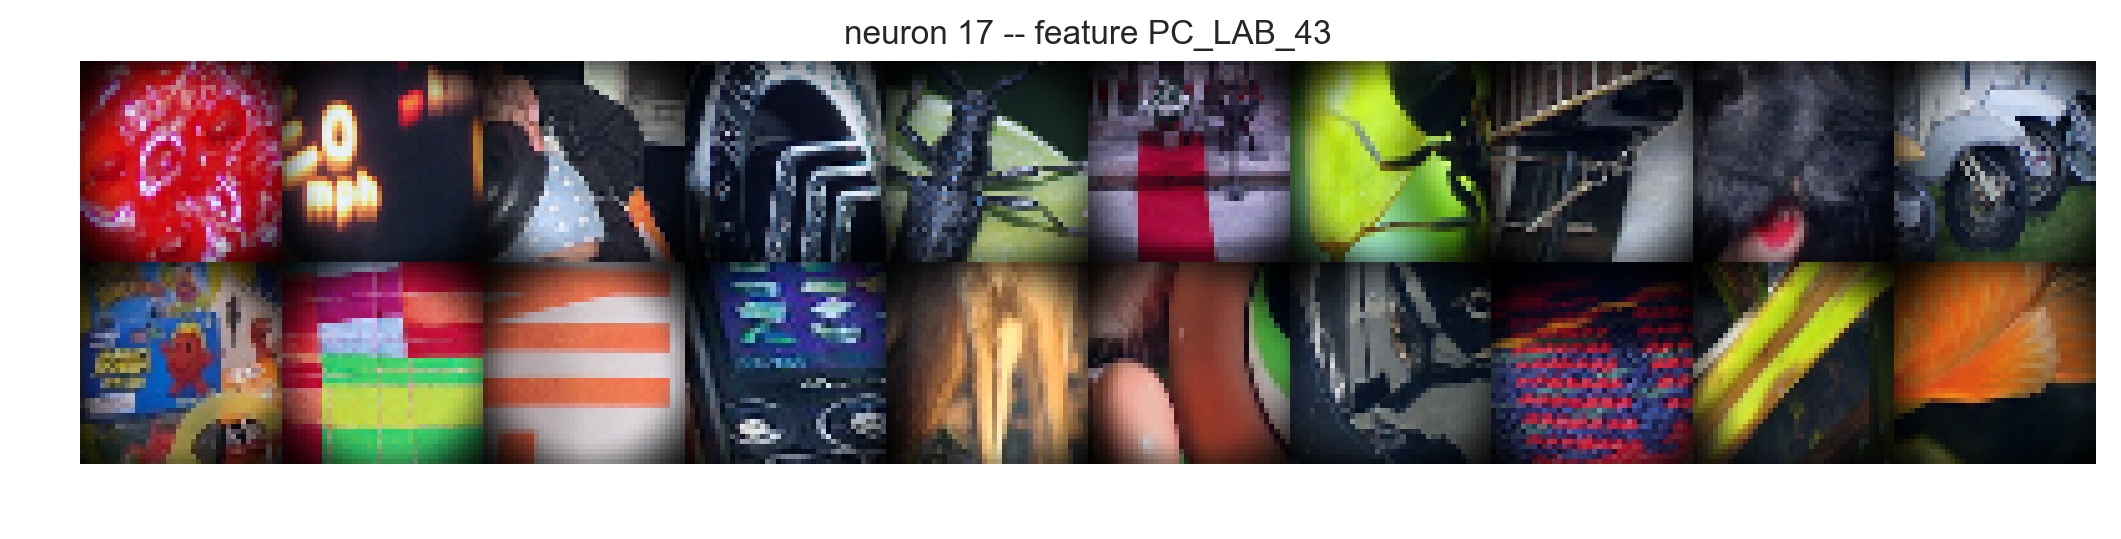

In [28]:
for i in range(importances.shape[0]):
    ixs = np.argsort(-importances[i])[:1]

    for ix in ixs:
        vals = X_all[:, ix]
        figure()
        visualize_feature(images, vals)
        title('neuron {} -- feature {}'.format(i, names[ix]))